# EDA

In [ ]:
!nvidia-smi

## Setup Environment

In [1]:
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

## Import Library

In [2]:
workspace_dir = '/nfs/Workspace/TeethSeg'
import sys
sys.path.append(workspace_dir)
import os

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    ToTensord,
    SqueezeDimd,
    LabelToMaskd
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.teeth_dataset import get_data_dicts
from data_utils.data_loader_utils import load_data_dict_json
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info

/opt/conda/envs/TeethSeg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare data dicts

In [3]:
data_dir = '/nfs/Workspace/dataset/teeth/cindydata'
data_json = os.path.join(data_dir, 'data.json')

In [ ]:
# data_dicts = get_data_dicts(data_dir)
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_json)

## Show data info

In [ ]:
data_info_df = get_data_info(tr_ds)

In [ ]:
data_info_df

In [ ]:
print('avg shape')
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
data_shape_df.mean()

In [ ]:
print('avg space')
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])
data_space_df.mean()

## Statcics

In [ ]:
data_dicts = tr_ds

base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=data_dicts,
    transform=base_tf
)

In [ ]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
min_percentile = 0.5
max_percentile = 99.5
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile,max_percentile)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [ ]:
print('data target space:')
data_target_space

In [ ]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', f'min_percentile ({min_percentile}%)', f'max_percentile ({max_percentile}%)']
)
data_intensities_statcics

## Transform

In [ ]:
space = data_target_space
a_min = s.data_min_percentile
a_max = s.data_max_percentile
teeth_transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          # ScaleIntensityRangePercentilesd(
          #     keys=["image"], lower=3, upper=97, b_min=0.0, b_max=1.0, clip=True
          # ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          ToTensord(keys=["image", "label"]),
          SqueezeDimd(keys=["image", "label"]),
      ]
  )

In [ ]:
tf_data_info_df = get_data_info(tr_ds, teeth_transform)

In [ ]:
from transforms.transform_utils import LabelToBinaryLabeld
space = [0.4, 0.4, 0.4]#data_target_space
a_min=218
a_max=3000
tooth_transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          LabelToBinaryLabeld(keys=["label"]),
          # LabelToMaskd(keys=["label"], select_labels=[i for i in range(1, 29)]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          # ScaleIntensityRangePercentilesd(
          #     keys=["image"], lower=1, upper=99, b_min=0.0, b_max=1.0, clip=True
          # ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          ToTensord(keys=["image", "label"]),
          SqueezeDimd(keys=["image", "label"]),
      ]
  )

In [ ]:
tf_data_info_df = get_data_info(tr_ds, tooth_transform)

## Check train/val dataloader

In [5]:
from data_utils.dataset import DataLoader
from expers.args import get_parser
from data_utils.visualization import show_img_lbl

In [6]:
data_dir = '/nfs/Workspace/dataset/teeth/cindydata'
data_json = os.path.join(data_dir, 'data.json')

In [10]:
args = get_parser([])
args.data_name = 'tooth'
args.data_dir = data_dir
args.data_dicts_json = data_json
args.scale_intensity_type='range'
args.select_label_num=29
args.a_min=218
args.a_max=3187
args.roi_x=96
args.roi_y=96
args.roi_z=96
args.space_x=0.4
args.space_y=0.4
args.space_z=0.4

In [11]:
tr_ld, val_dl = DataLoader(args.data_name, args)

use scale intensity by range
use scale intensity by range
load json from /nfs/Workspace/dataset/teeth/cindydata/data.json
train files (11): ['1001152328_20150714', '1001162439_20140520', '1001162439_20150708', '1001172283_20190622', '1001213121_20180115', '1001218388_20161024', '1001223657_20180112', '1001263197_20180115', '1001275319_20180114', '1001277267_20180112', '1001377656_20171105']
val files (10): ['1001377656_20180116', '1001381644_20180112', '1001382496_20180112', '1001382496_20180423', '1001382496_20201206', '1001384881_20180110', '1001398270_20180111', '1001470164_20180114', '1001484858_20150118', '1001484858_20180109']
test files (5): ['1001486953_20180109', '1001487462_20170505', '1001487462_20180109', '1001487462_20180527', '1001487462_20190427']

load train dataset ...


Loading dataset: 100%|██████████| 11/11 [00:29<00:00,  2.70s/it]



load val dataset ...


Loading dataset: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


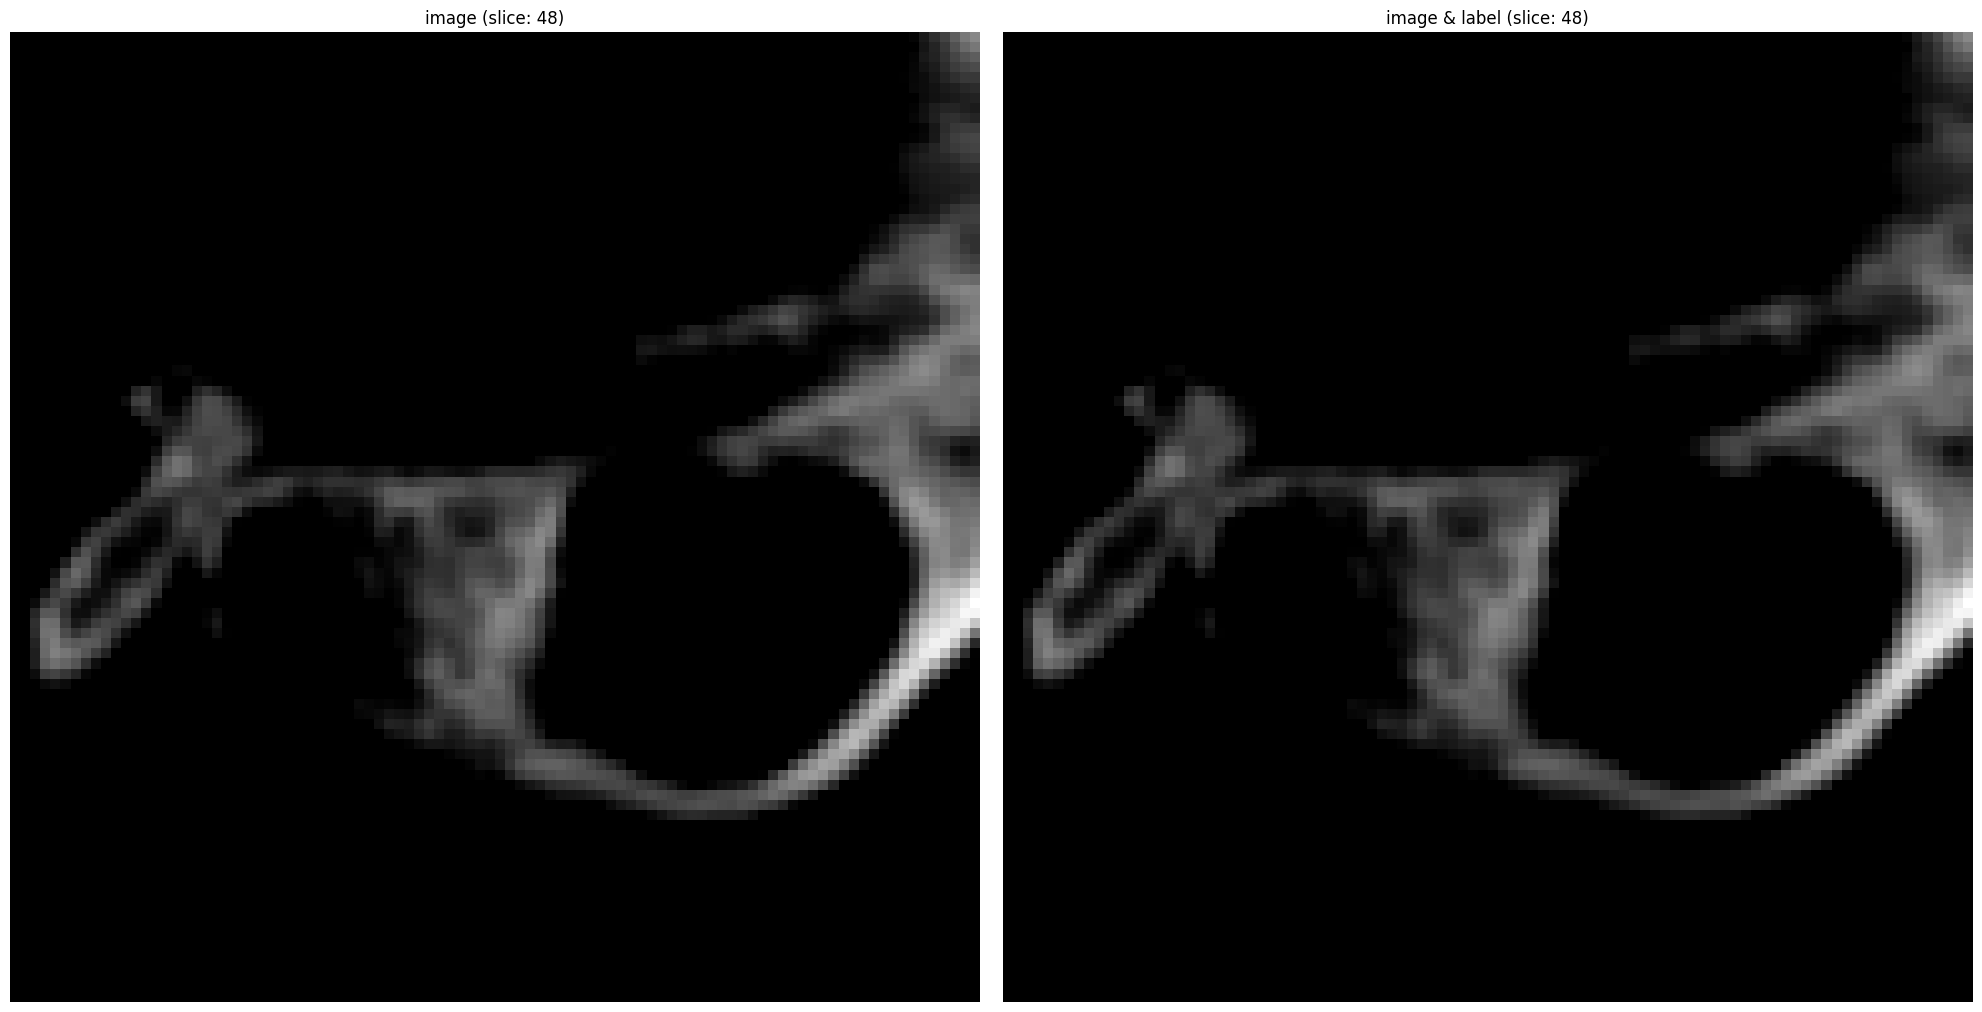

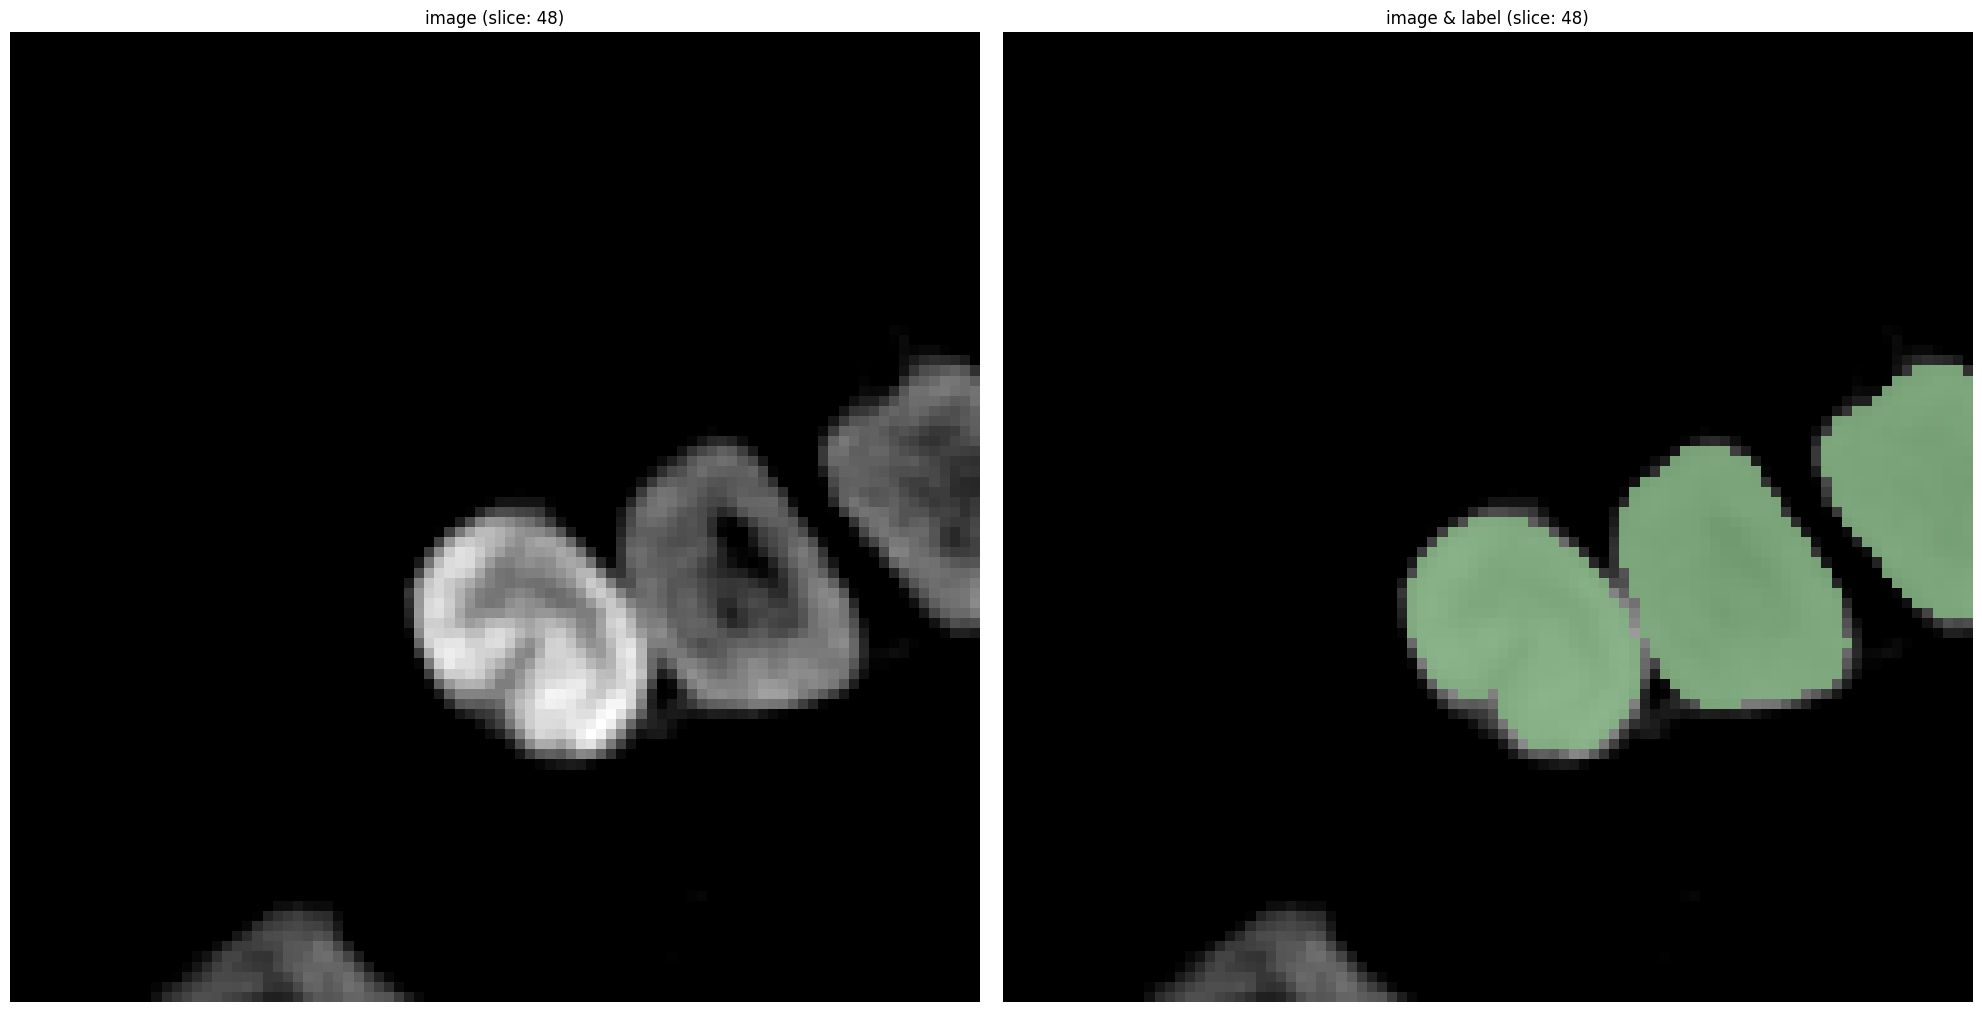

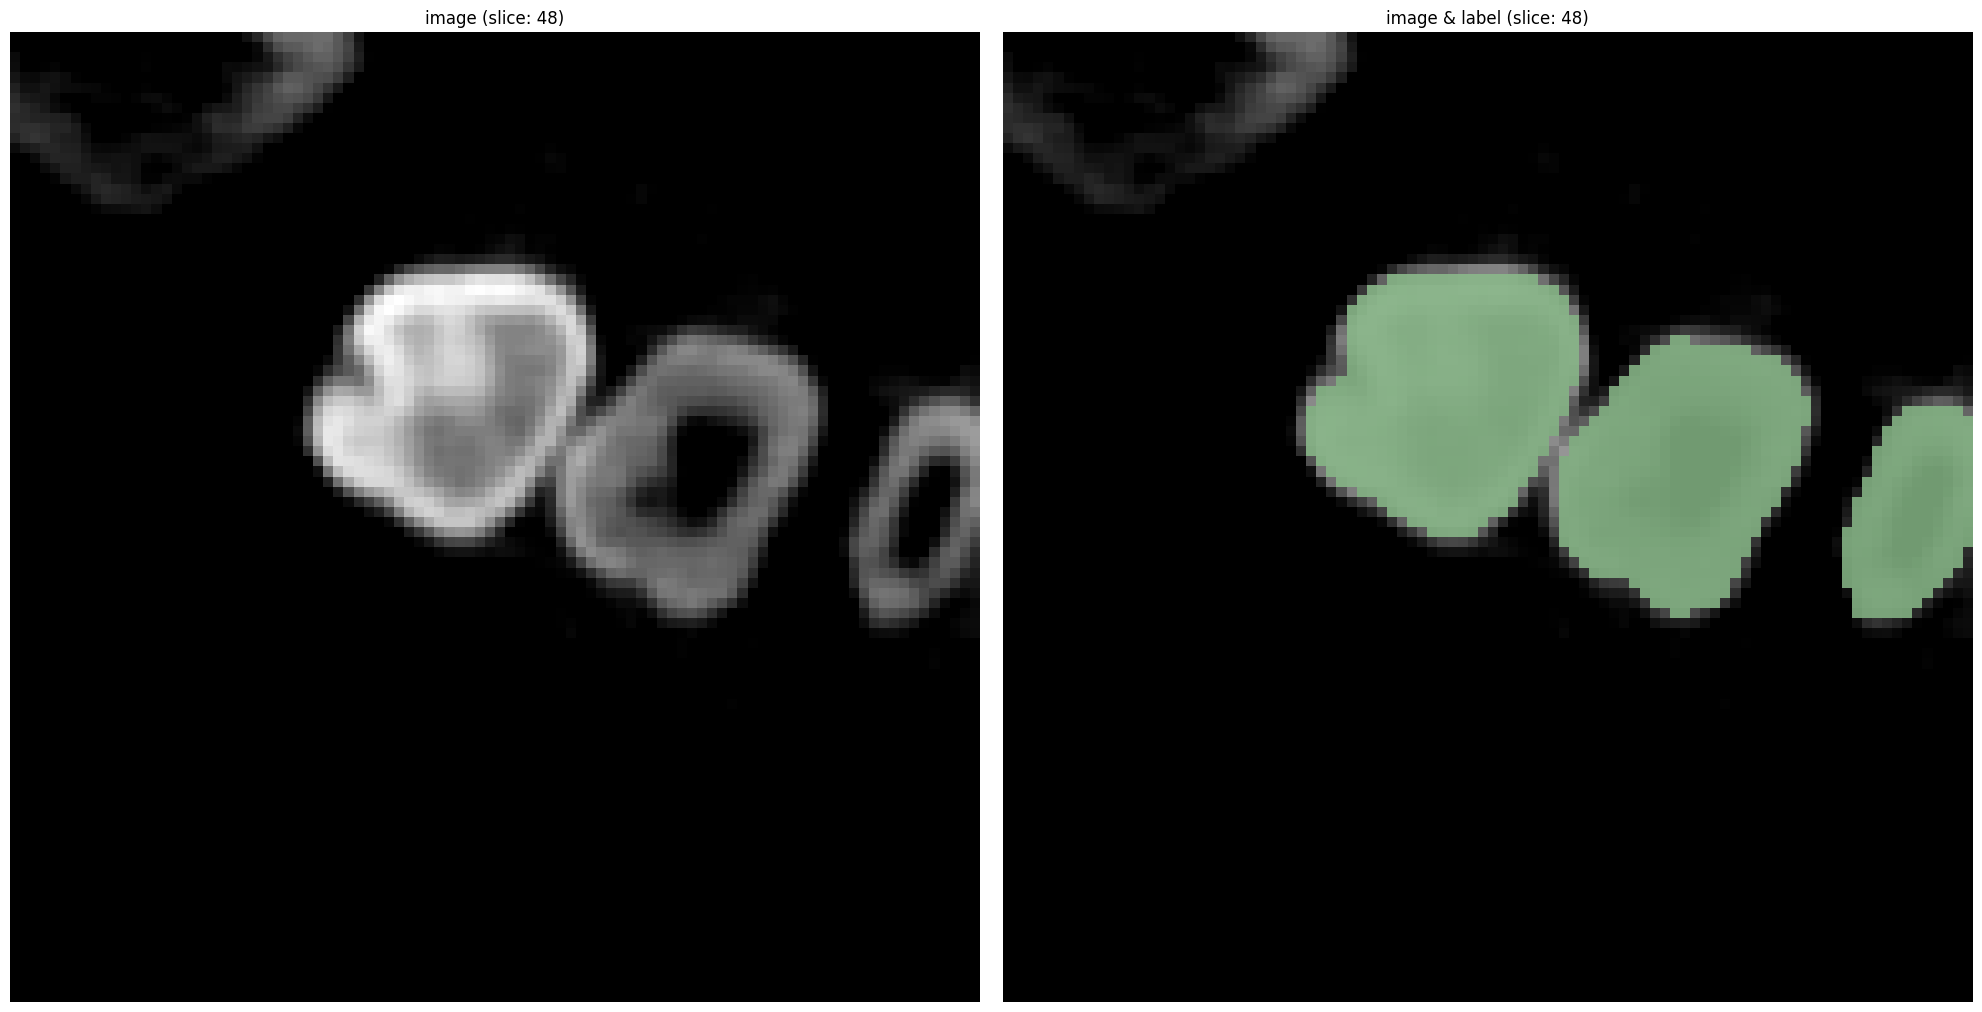

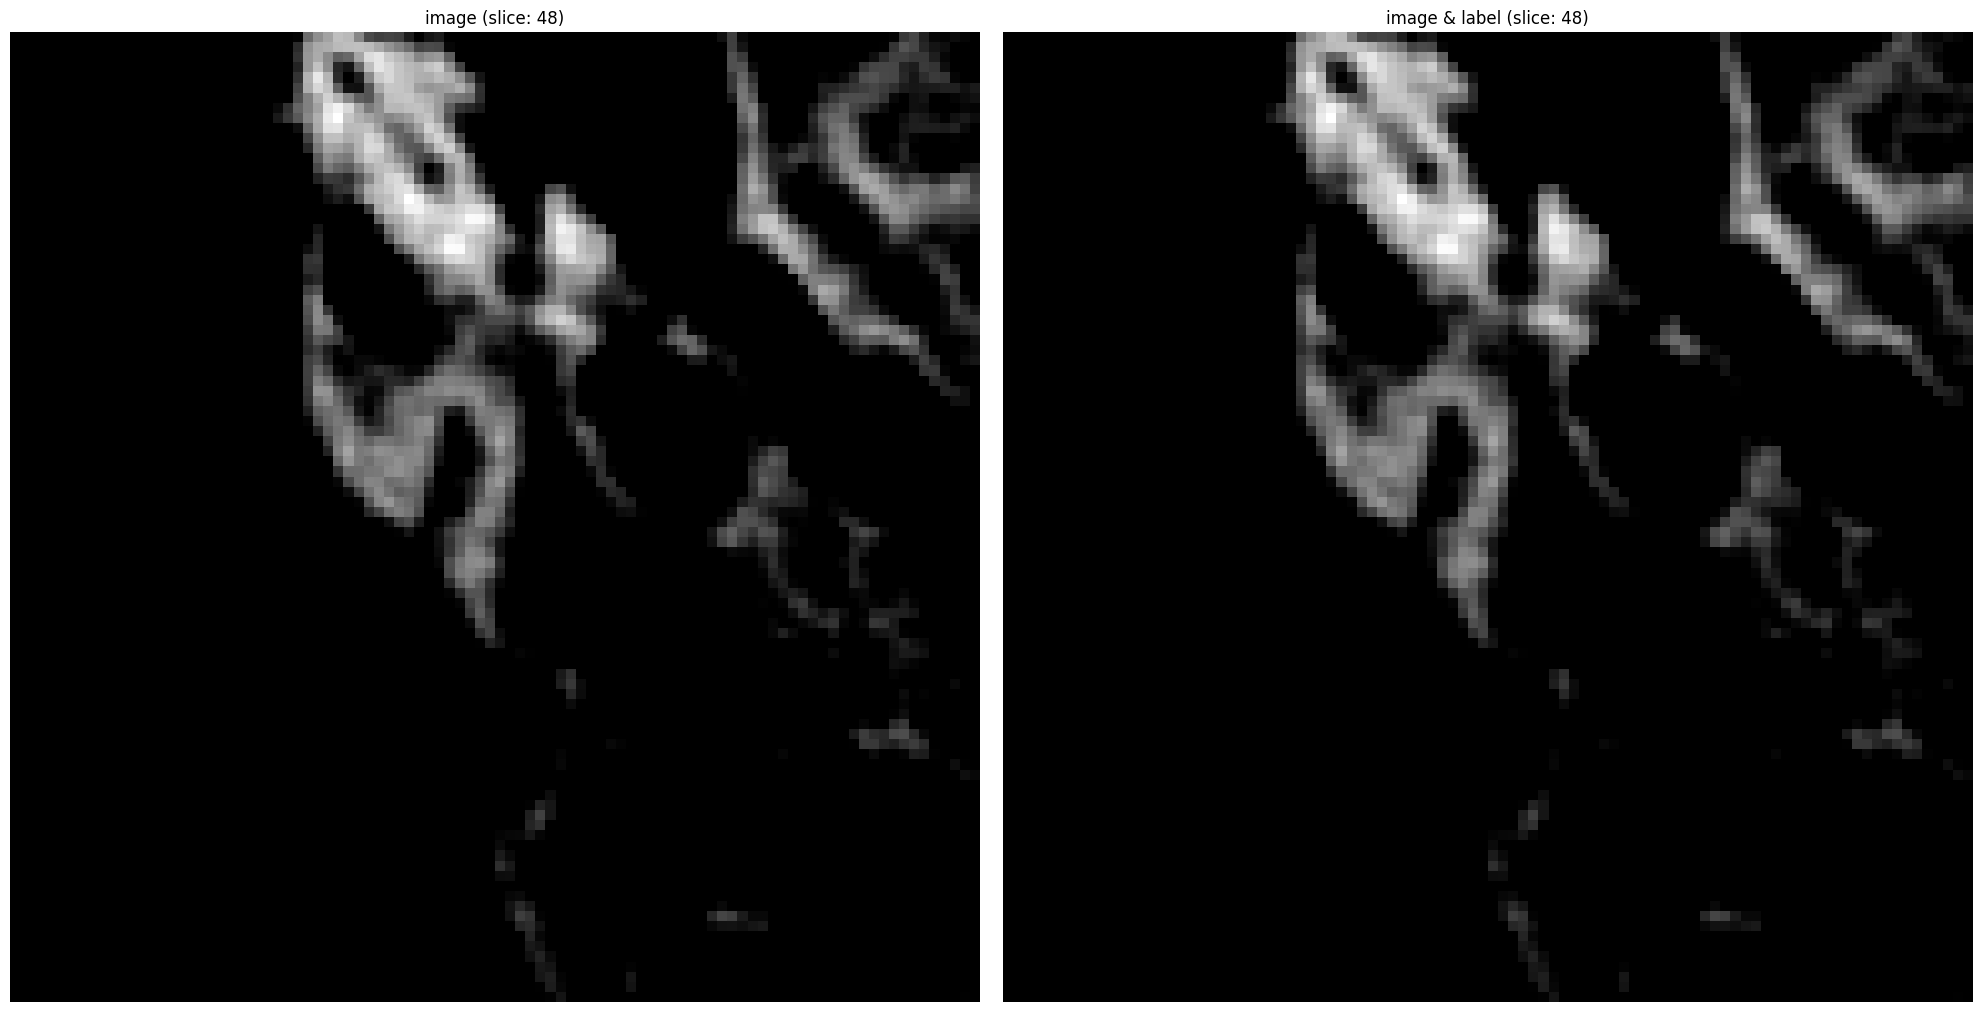

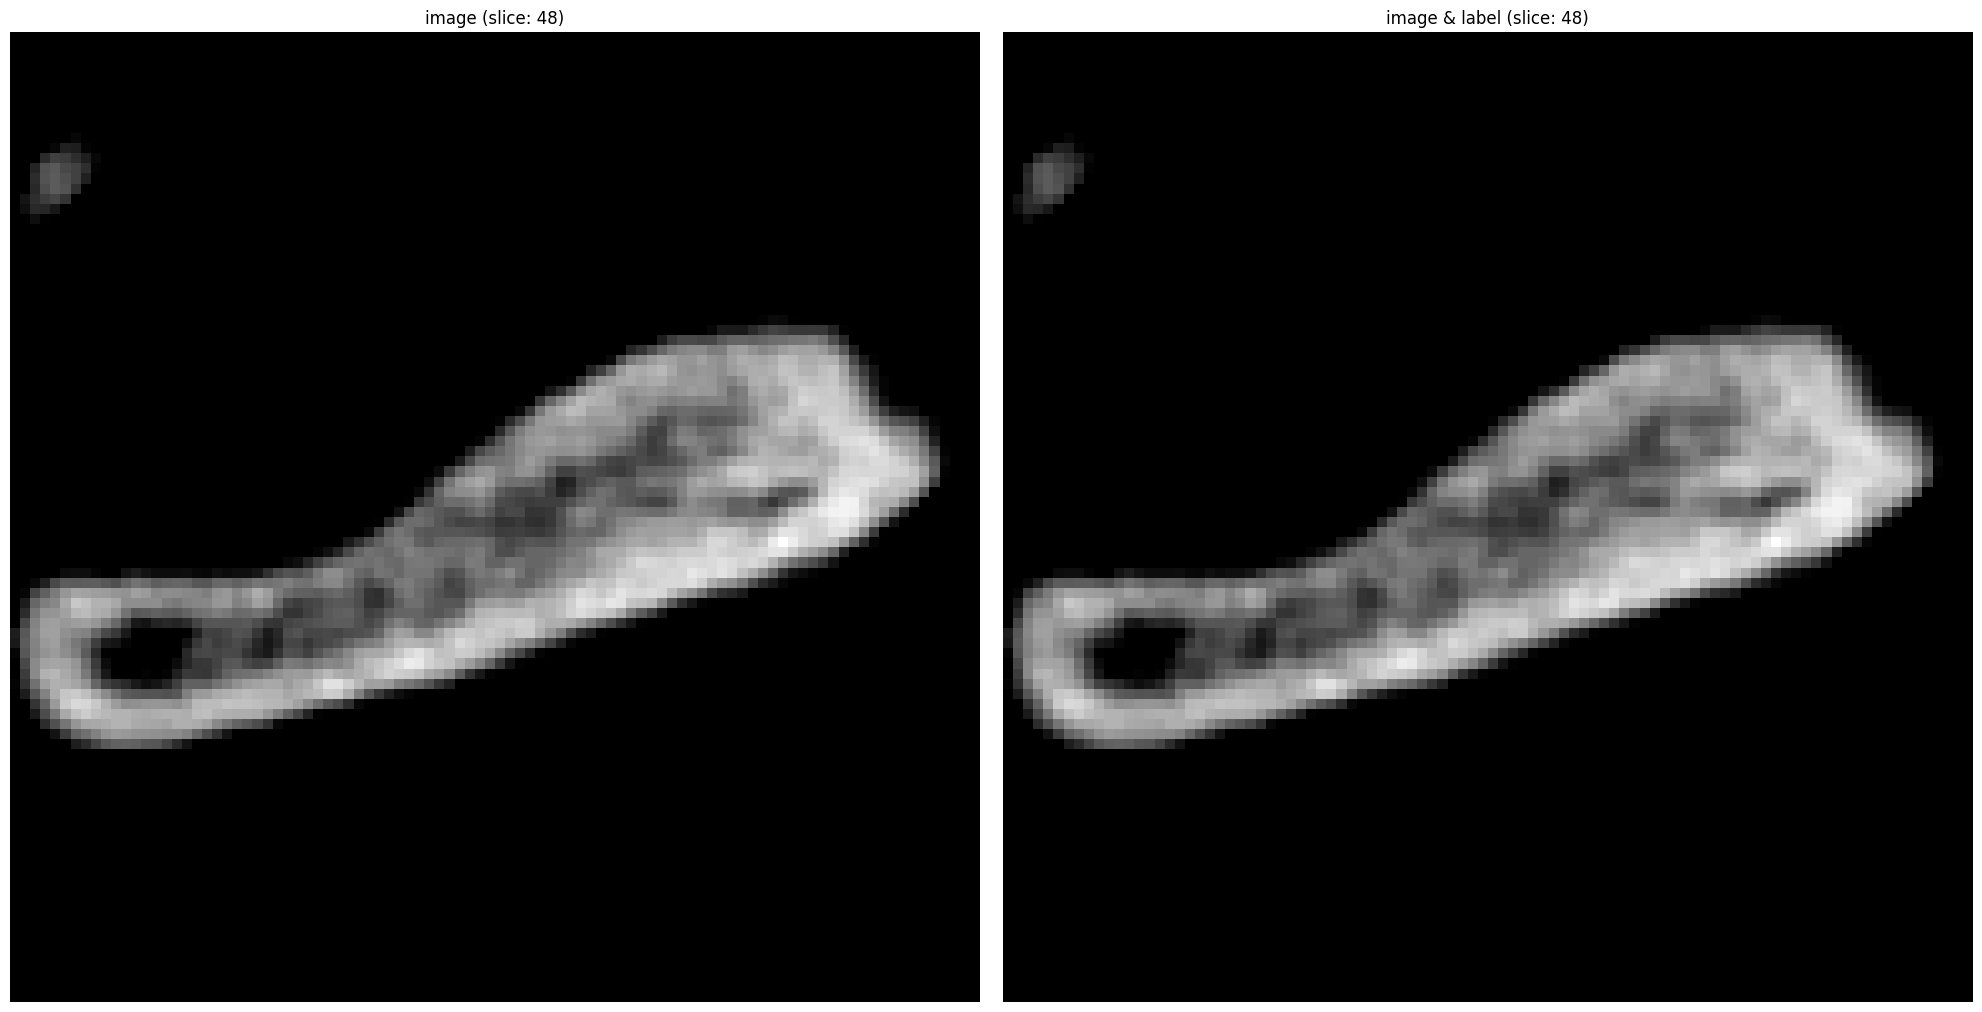

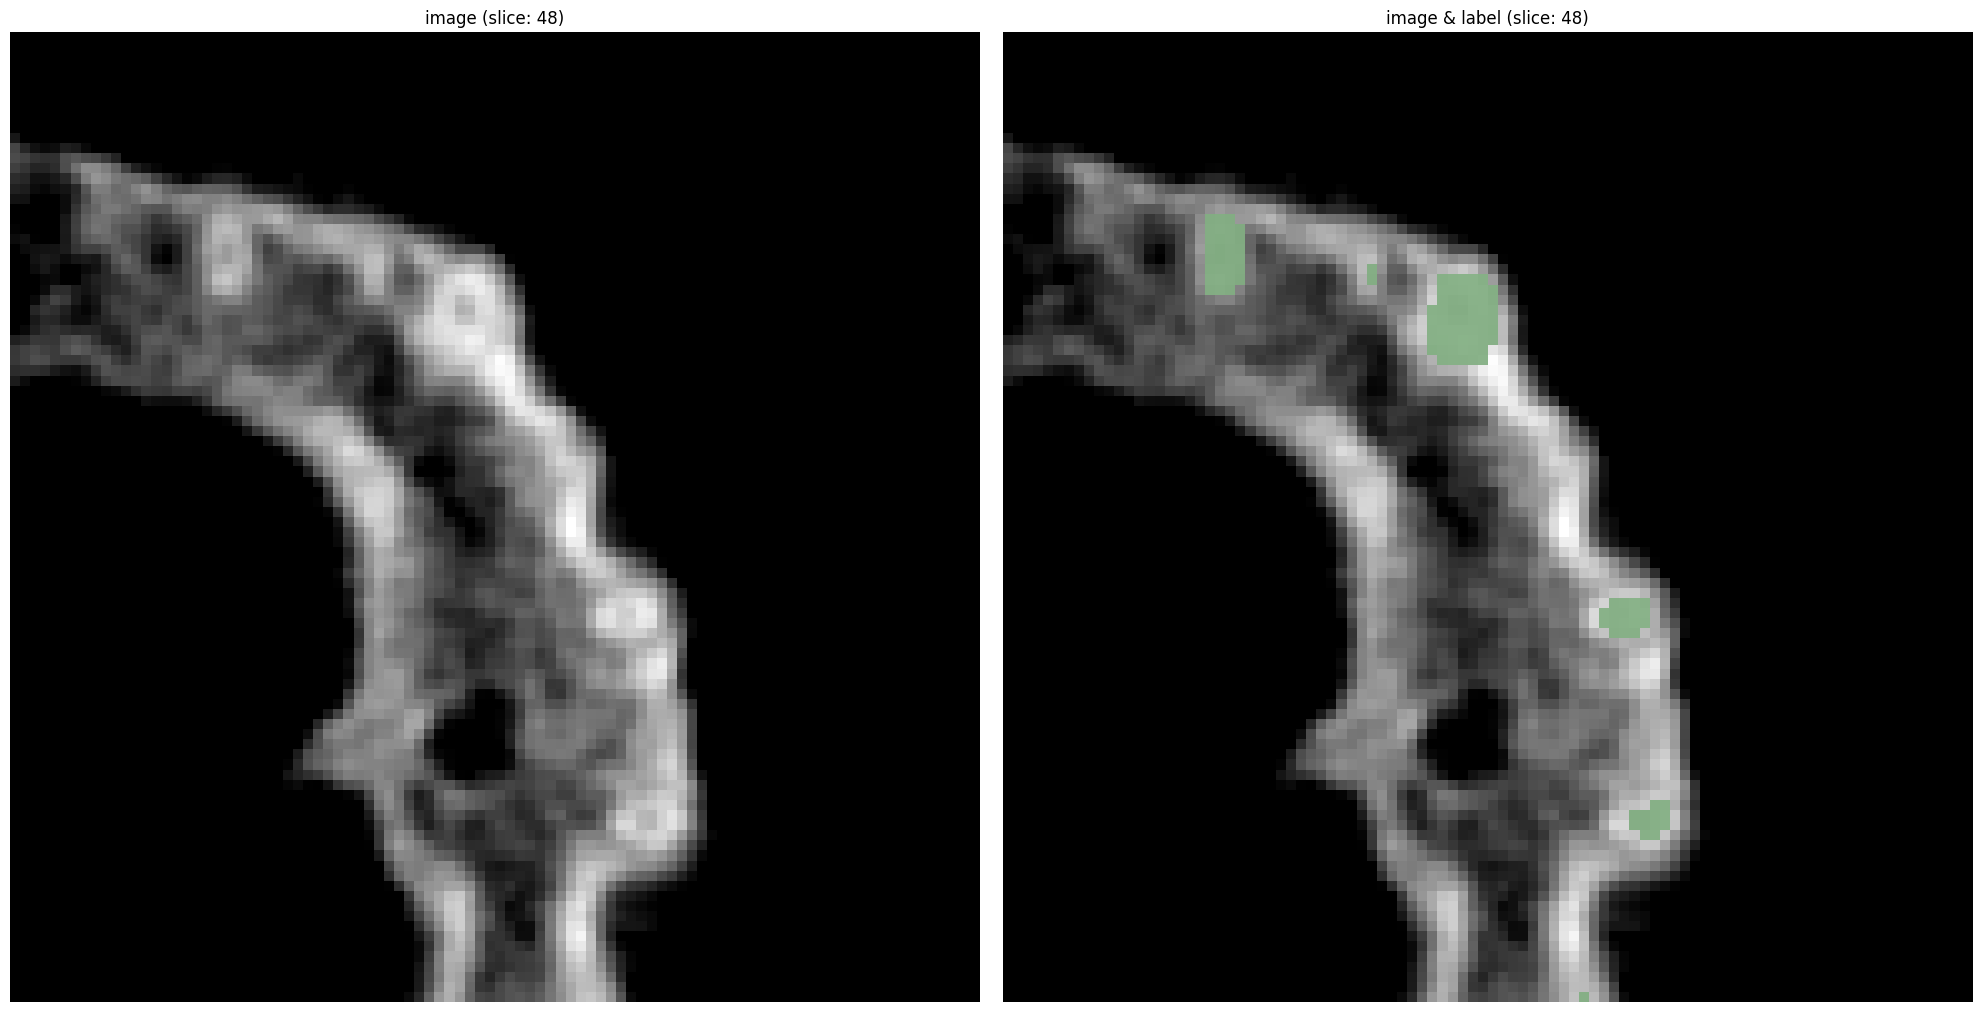

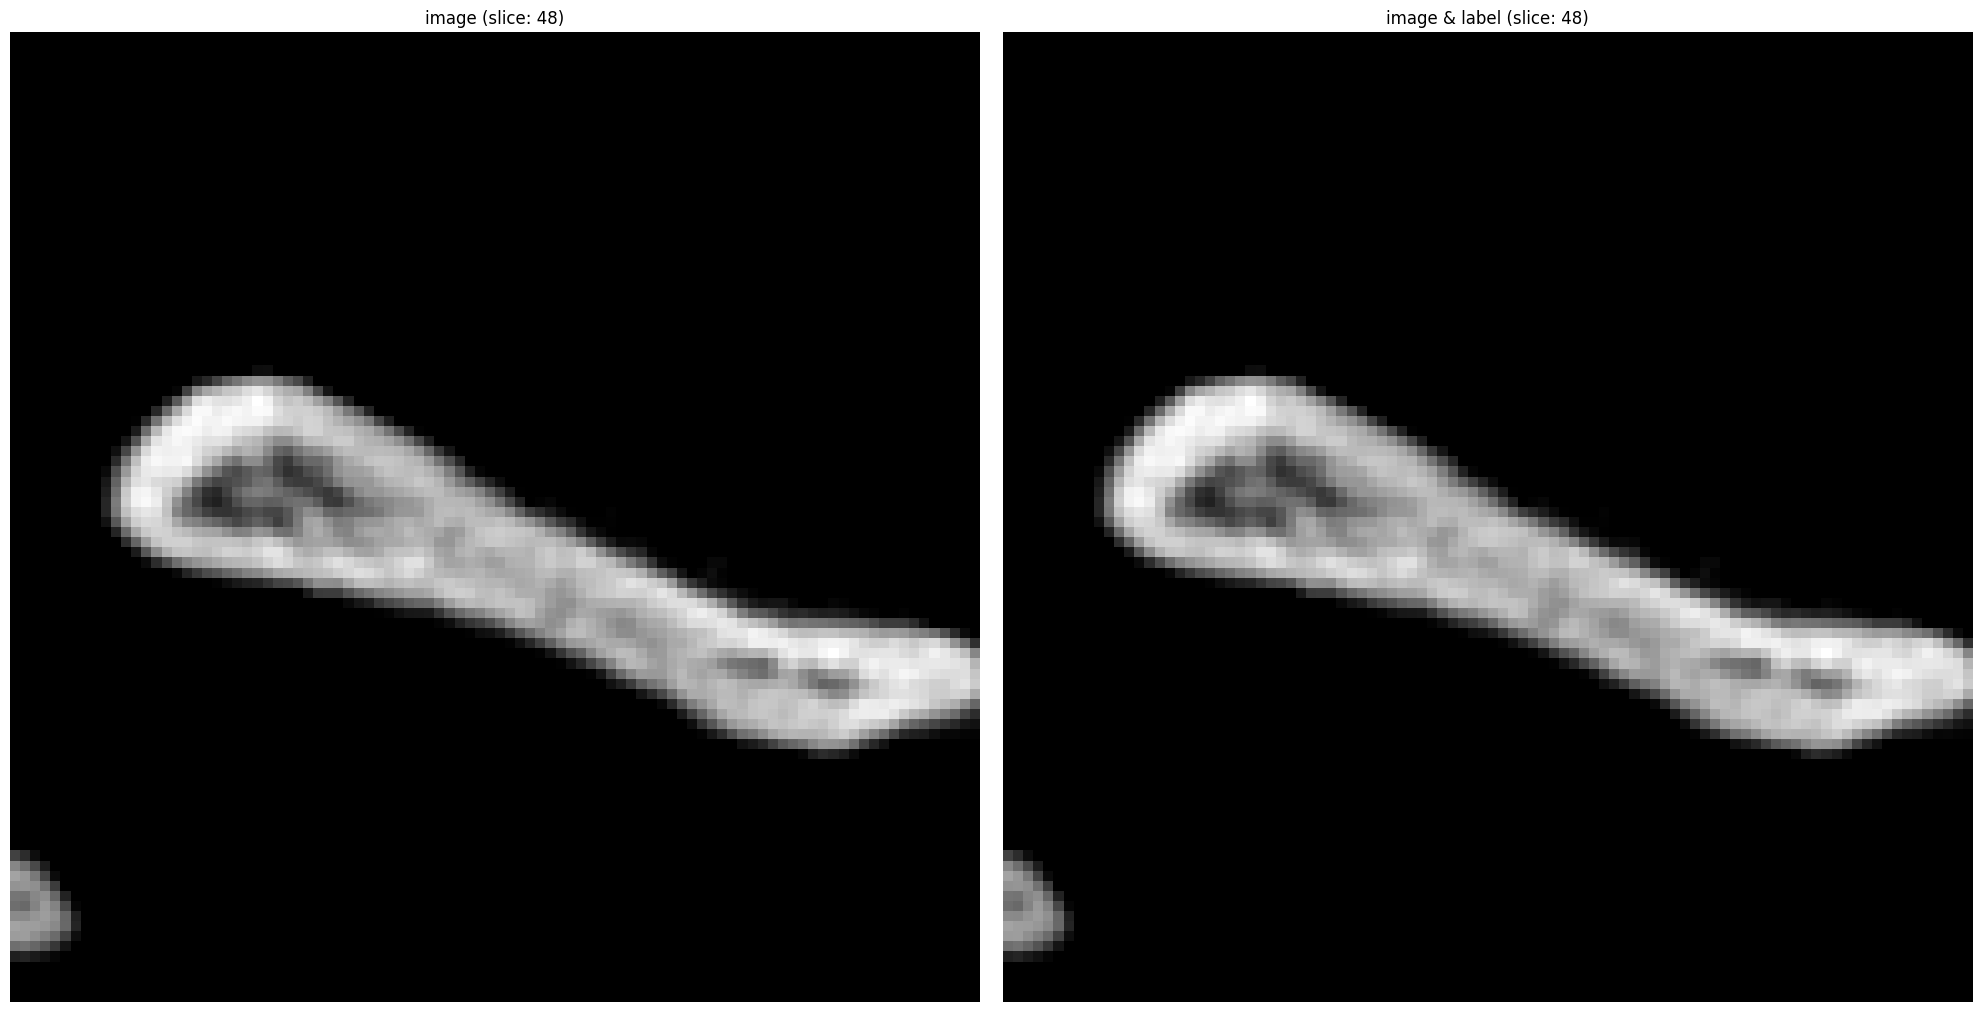

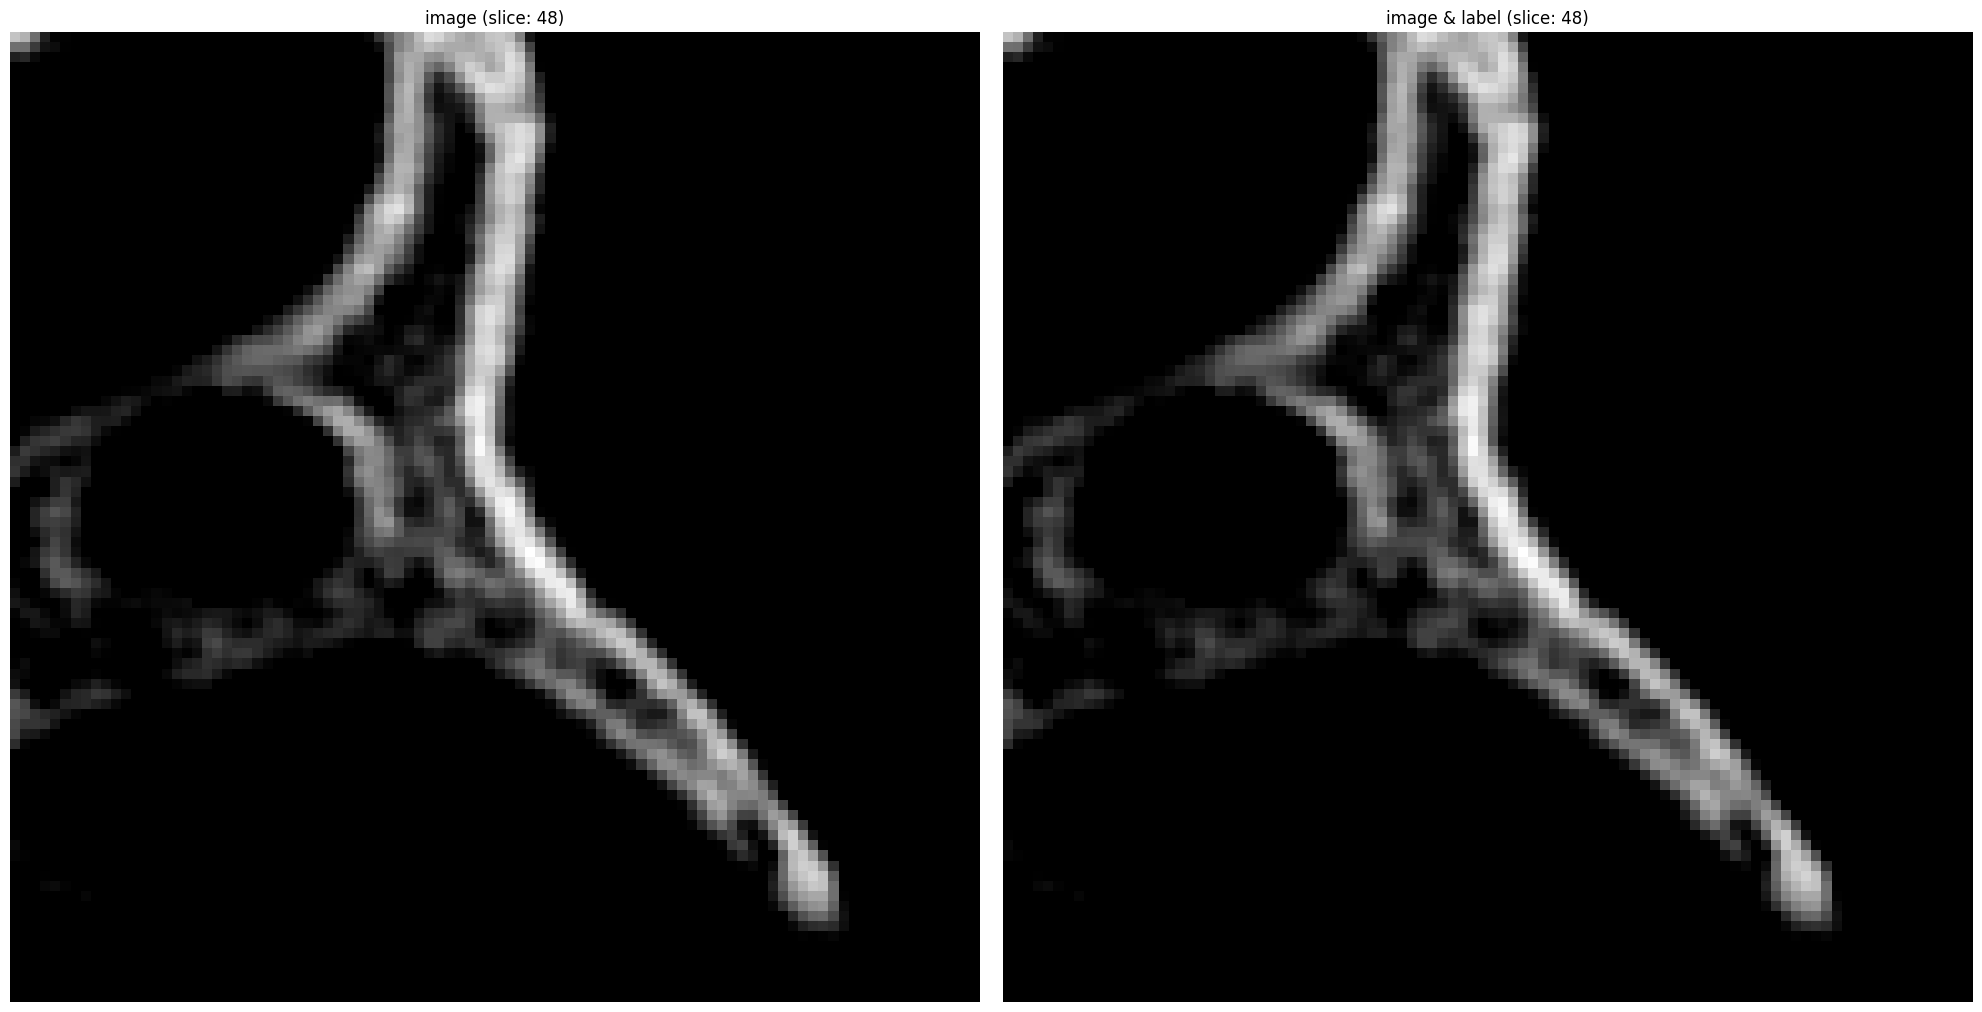

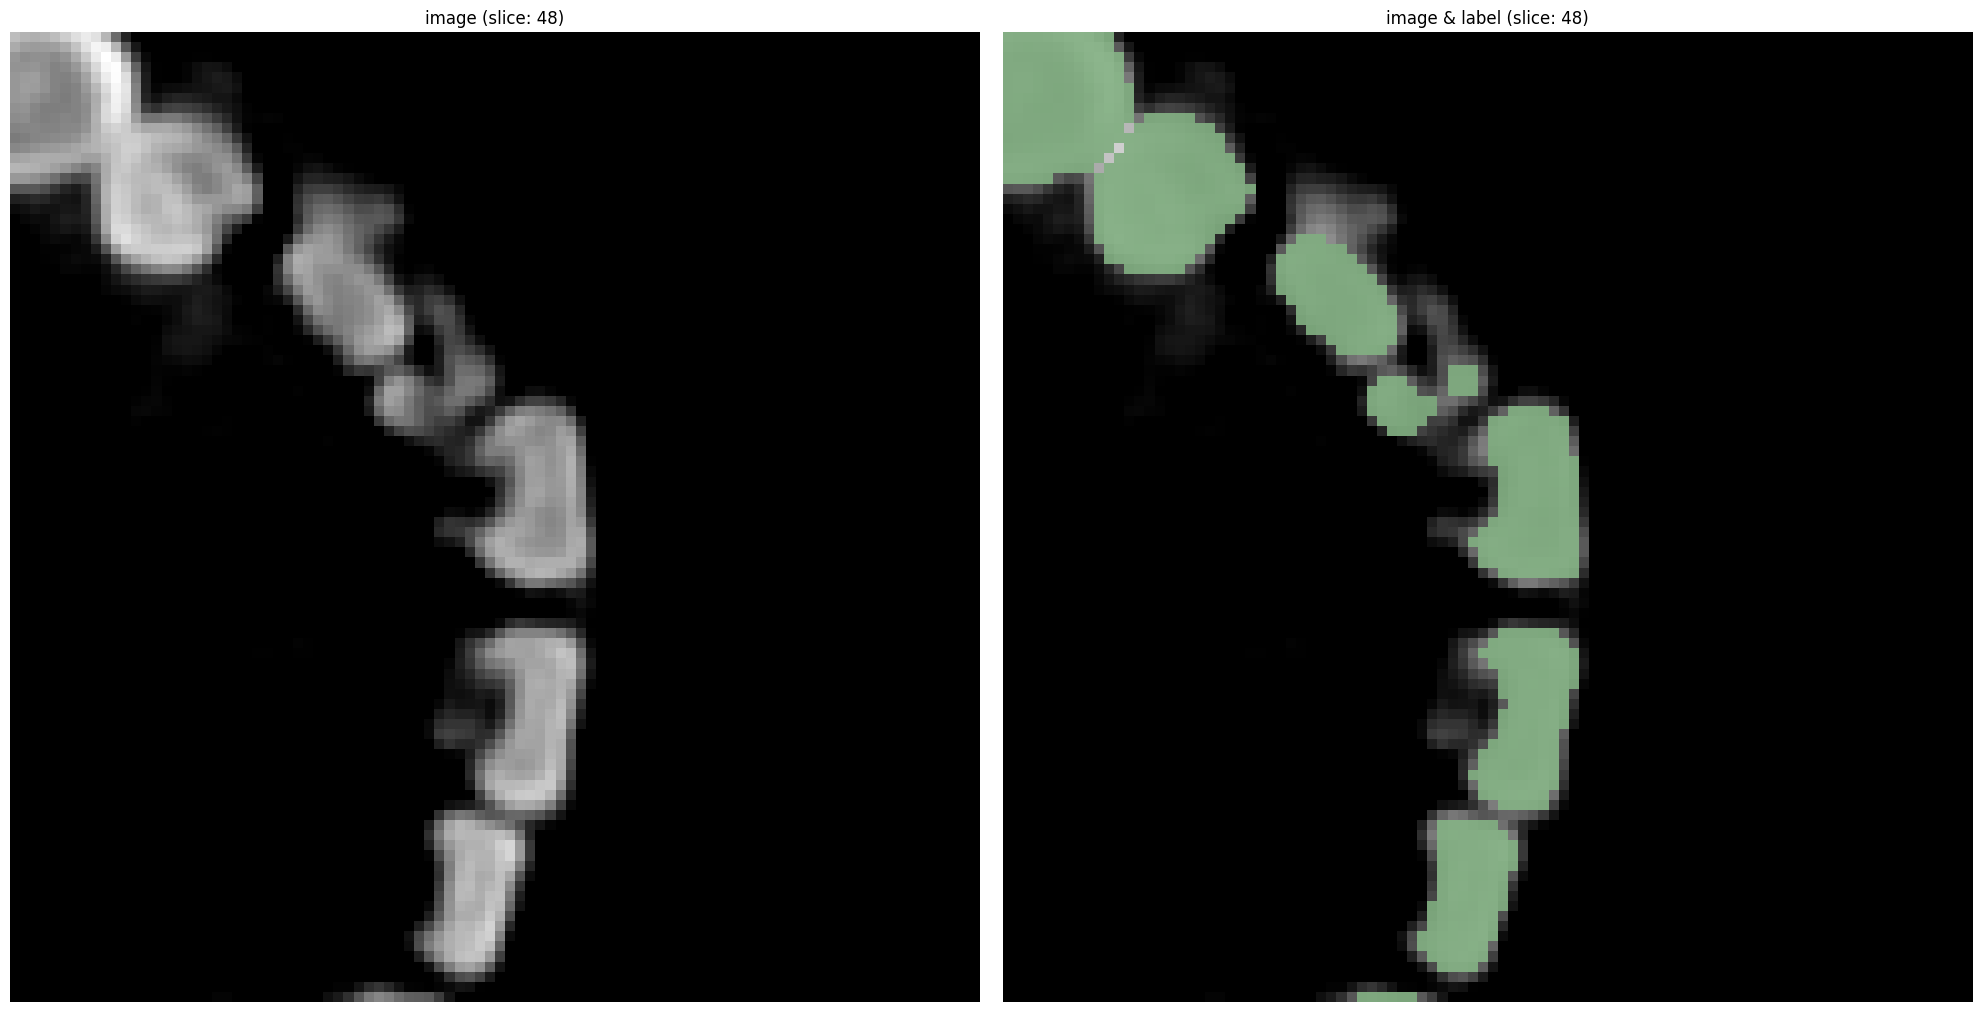

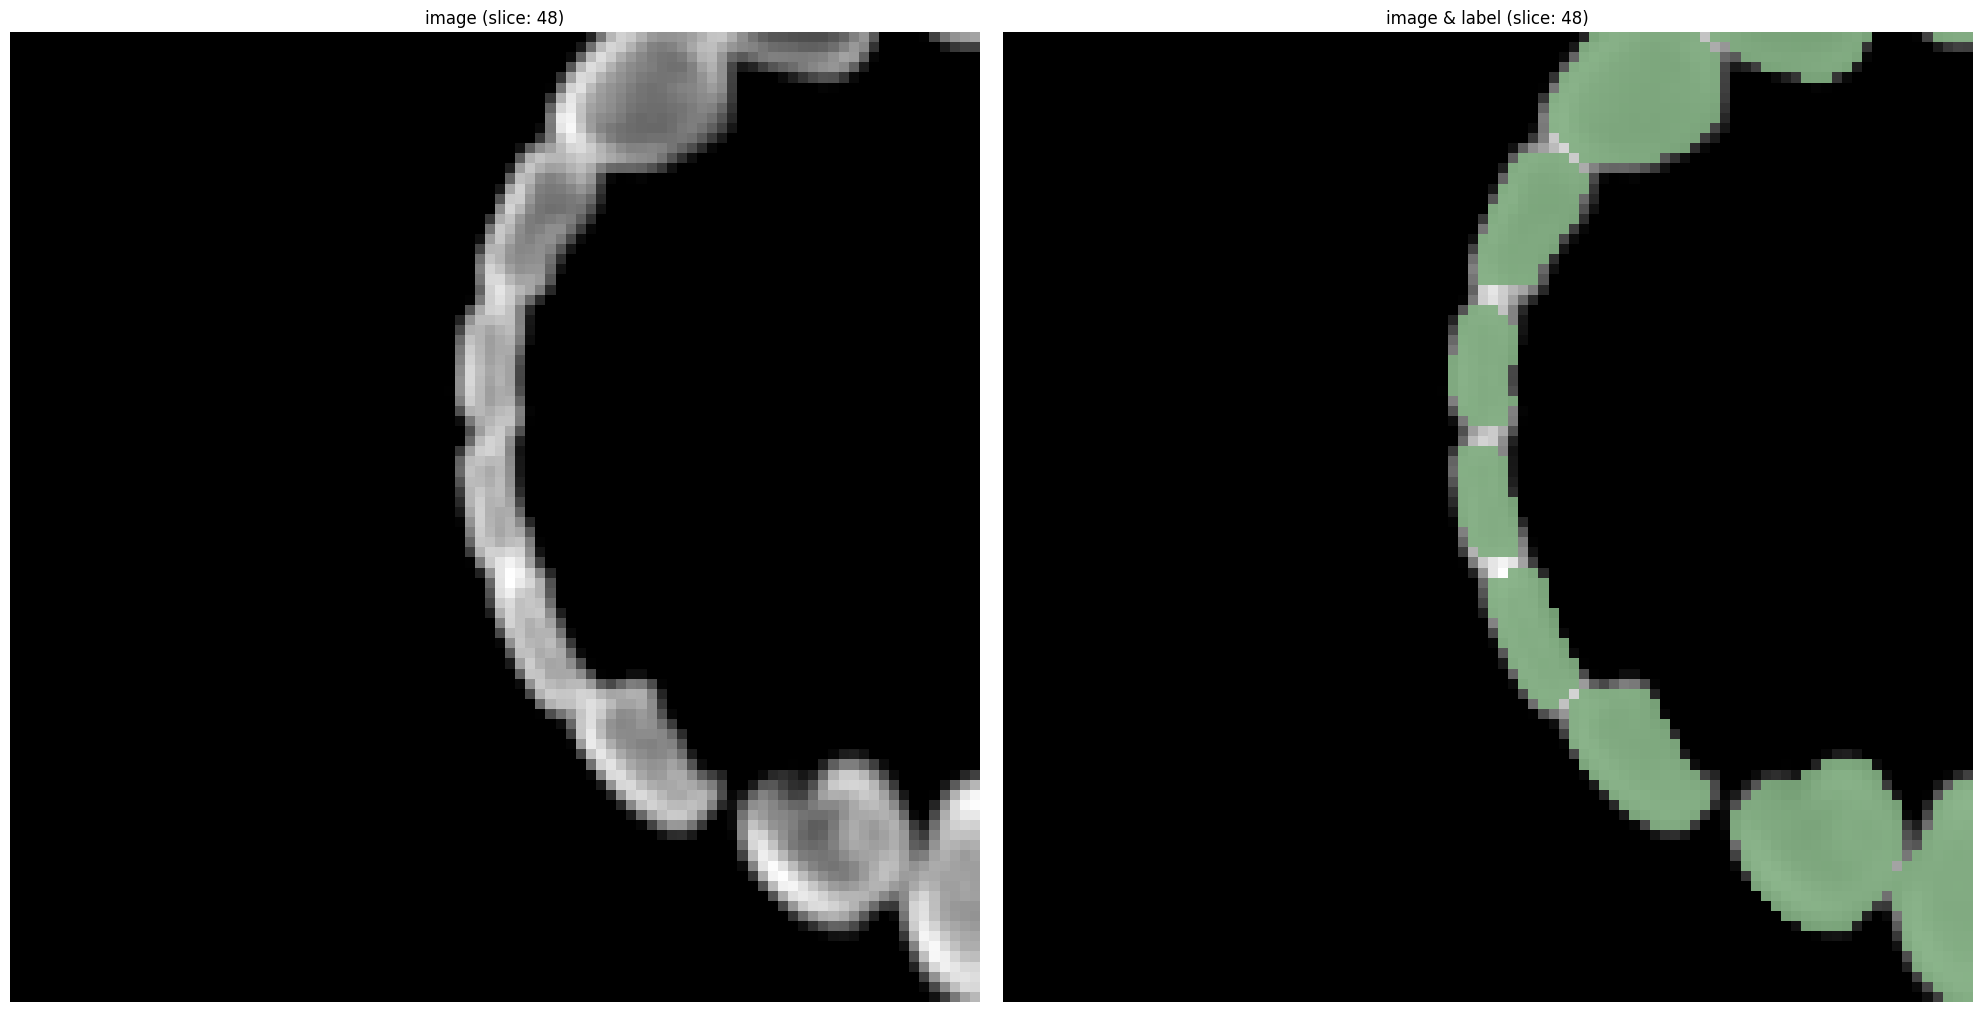

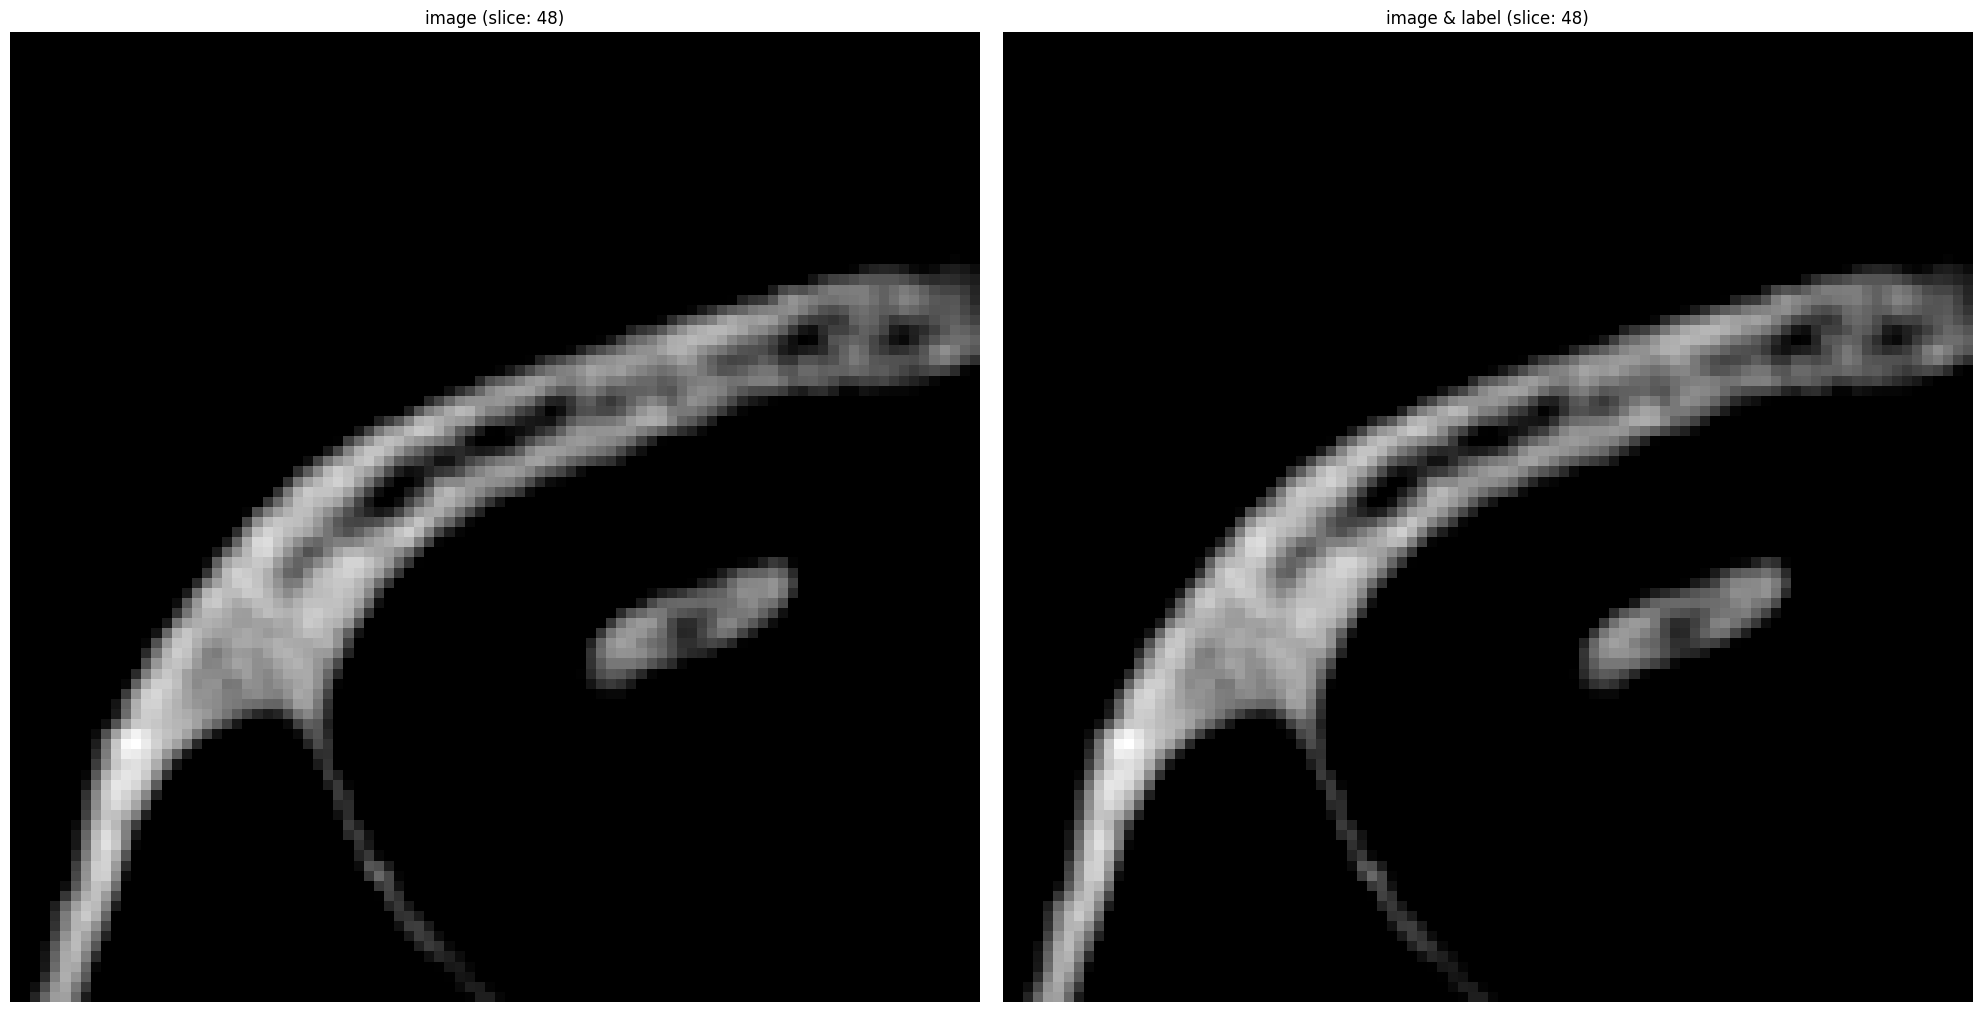

In [12]:
slice_idx = 48
num_classes = 2
for d in tr_ld:
    show_img_lbl(
        d['image'][0,0,:,:,slice_idx], 
        d['label'][0,0,:,:,slice_idx], 
        slice_idx=slice_idx,
        num_classes=num_classes
    )

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


use scale intensity by range
use scale intensity by range
load json from /nfs/Workspace/dataset/teeth/cindydata/data.json
train files (11): ['1001152328_20150714', '1001162439_20140520', '1001162439_20150708', '1001172283_20190622', '1001213121_20180115', '1001218388_20161024', '1001223657_20180112', '1001263197_20180115', '1001275319_20180114', '1001277267_20180112', '1001377656_20171105']
val files (10): ['1001377656_20180116', '1001381644_20180112', '1001382496_20180112', '1001382496_20180423', '1001382496_20201206', '1001384881_20180110', '1001398270_20180111', '1001470164_20180114', '1001484858_20150118', '1001484858_20180109']
test files (5): ['1001486953_20180109', '1001487462_20170505', '1001487462_20180109', '1001487462_20180527', '1001487462_20190427']

load train dataset ...


Loading dataset: 100%|██████████| 11/11 [00:31<00:00,  2.87s/it]



load val dataset ...


Loading dataset: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


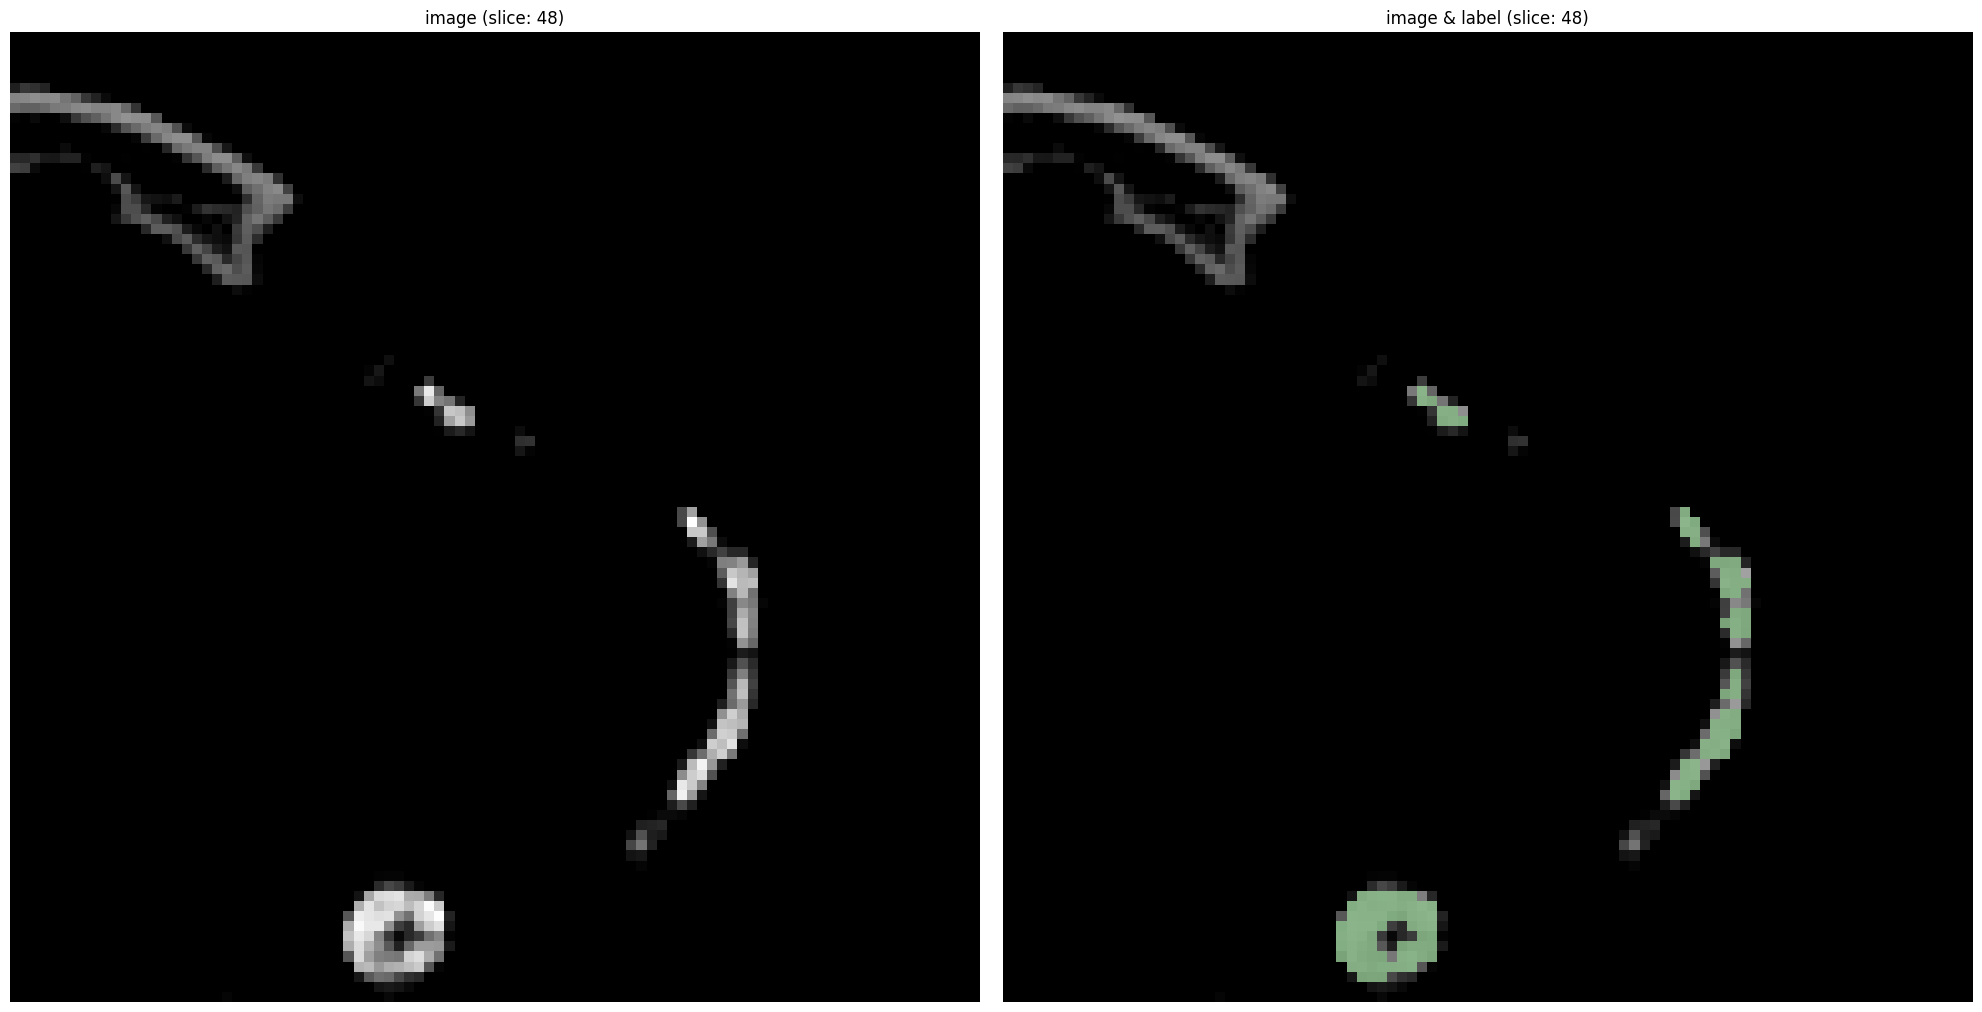

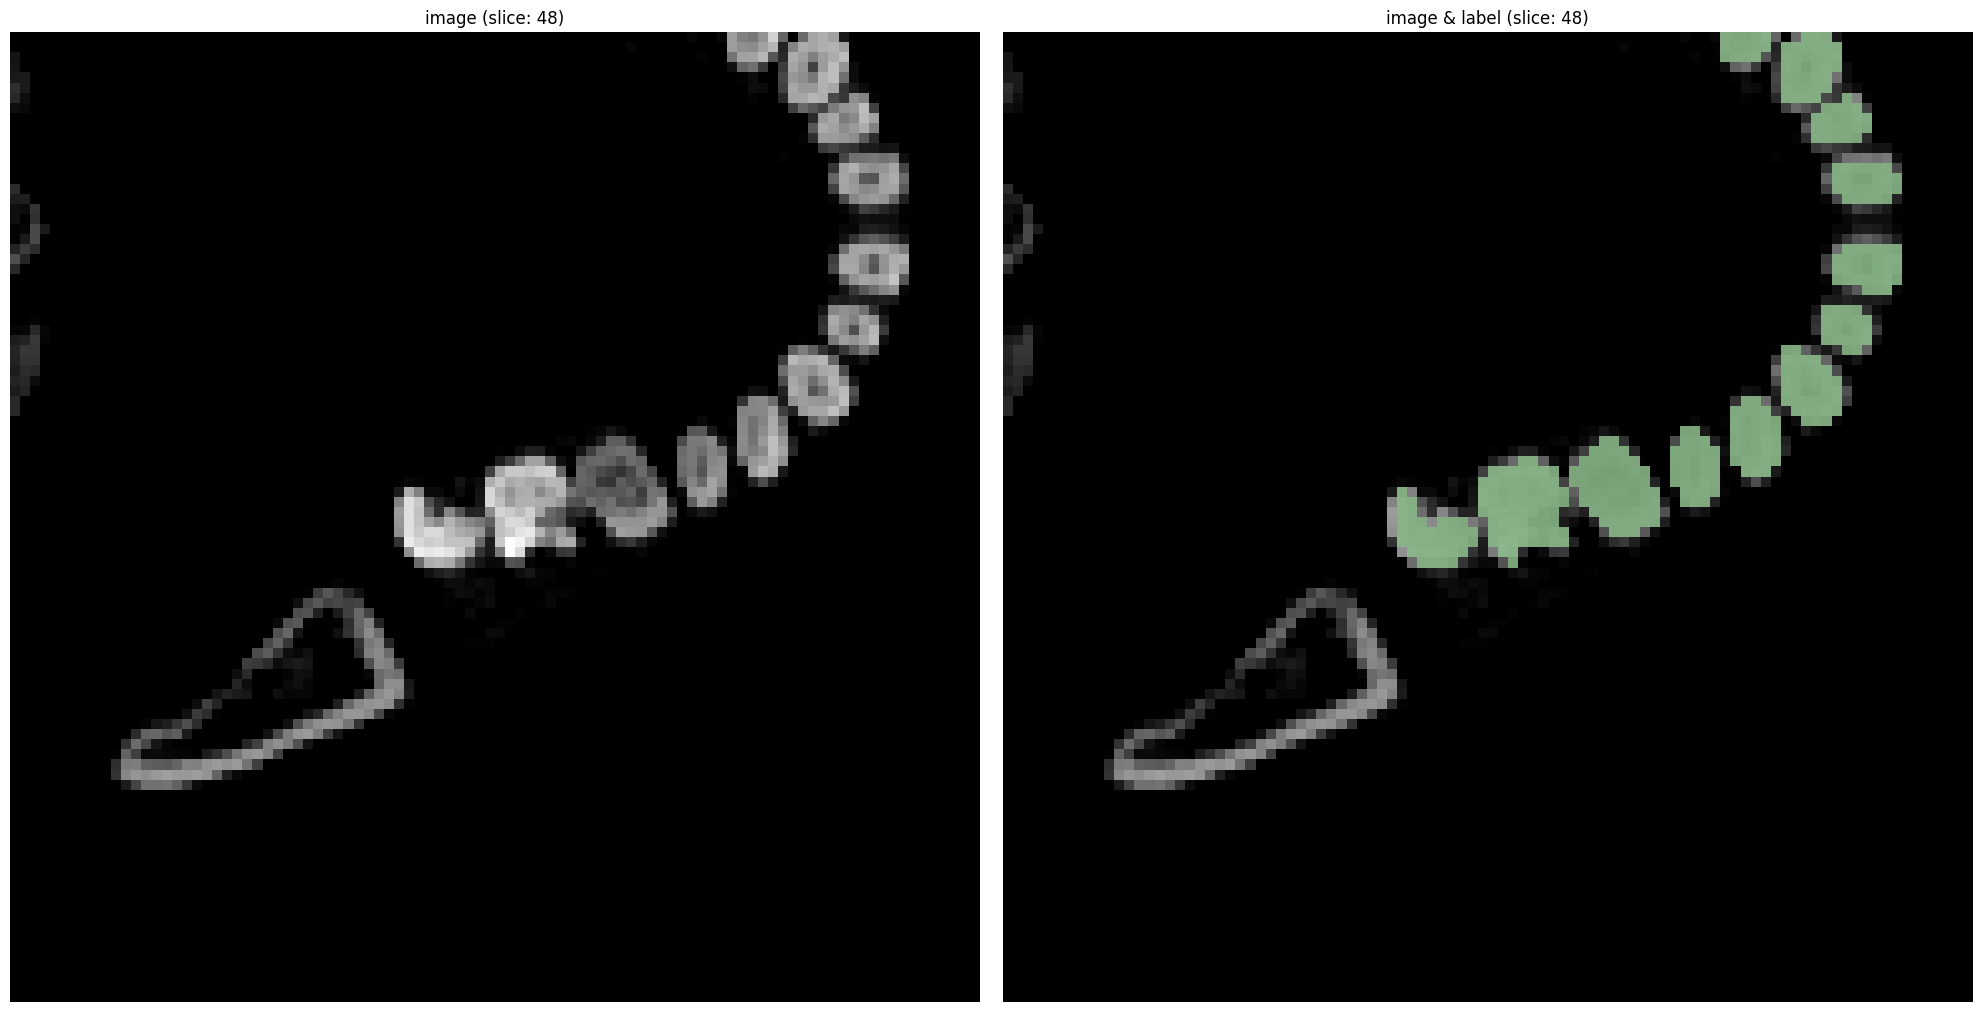

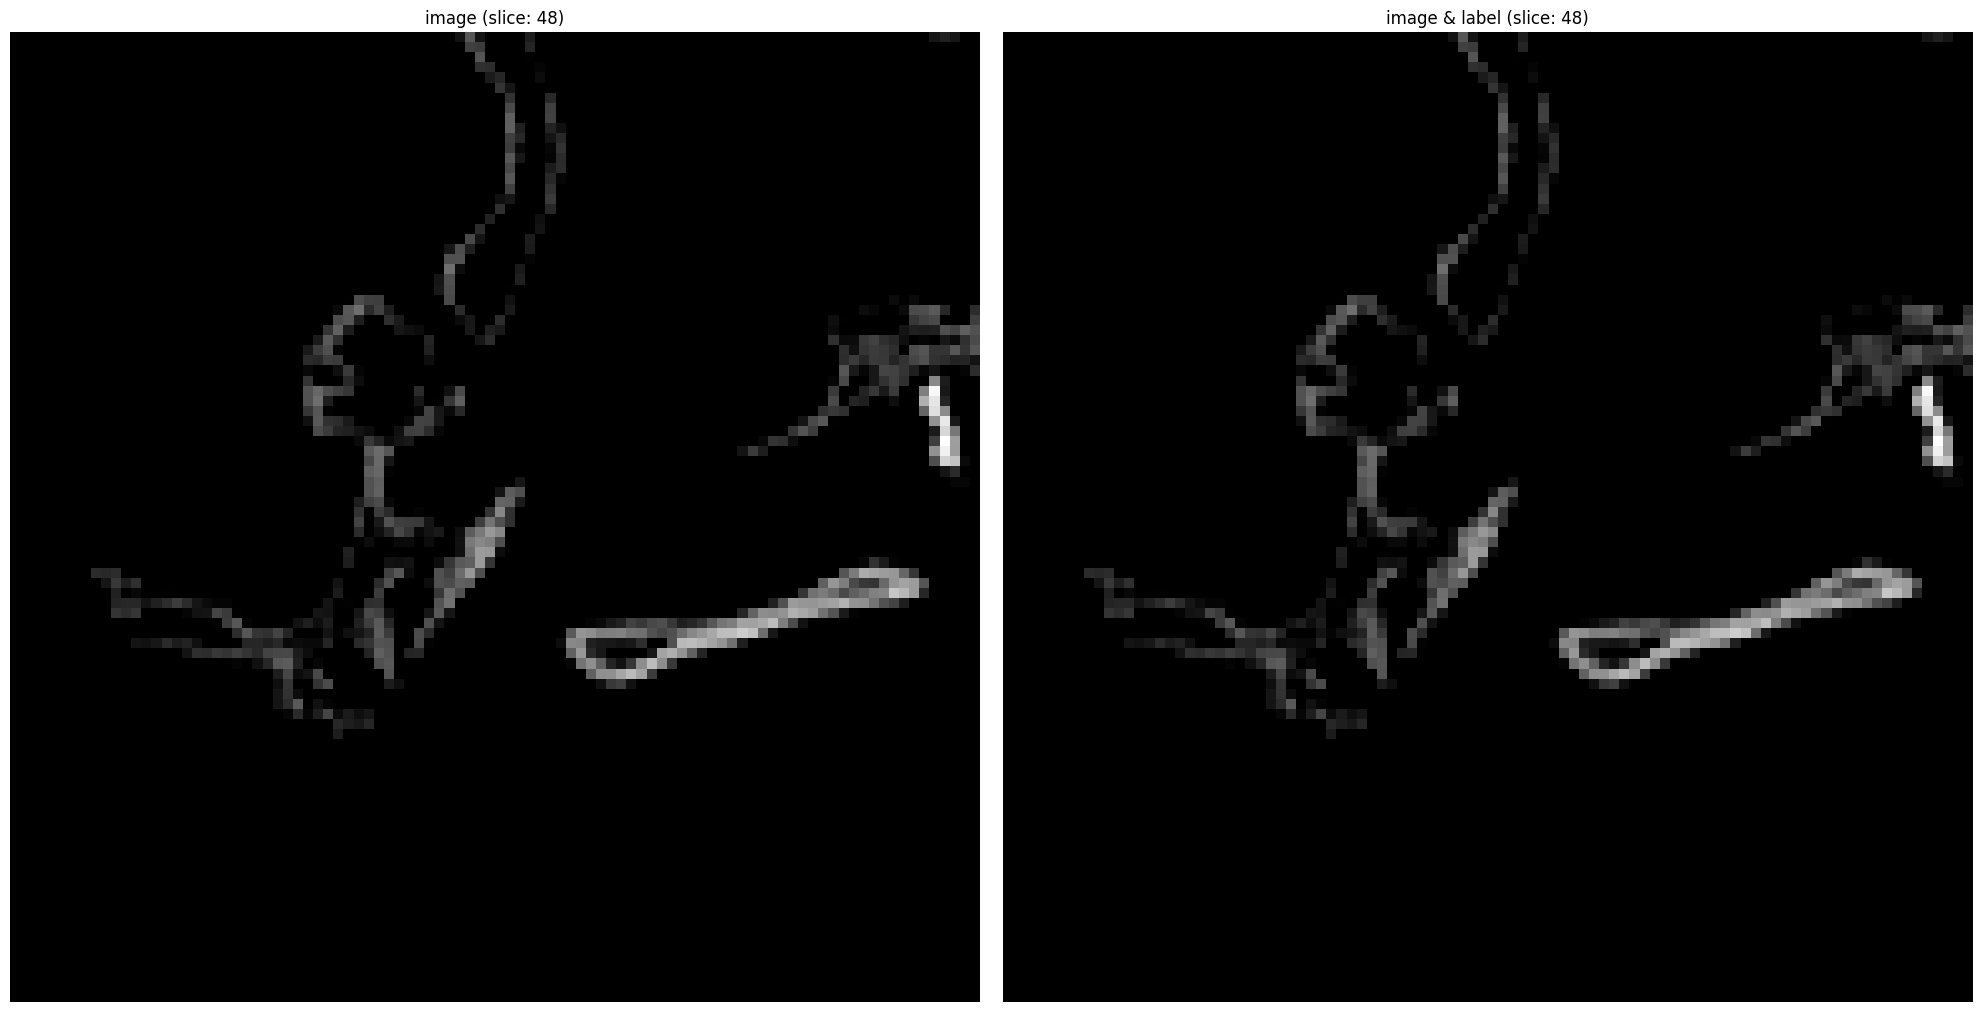

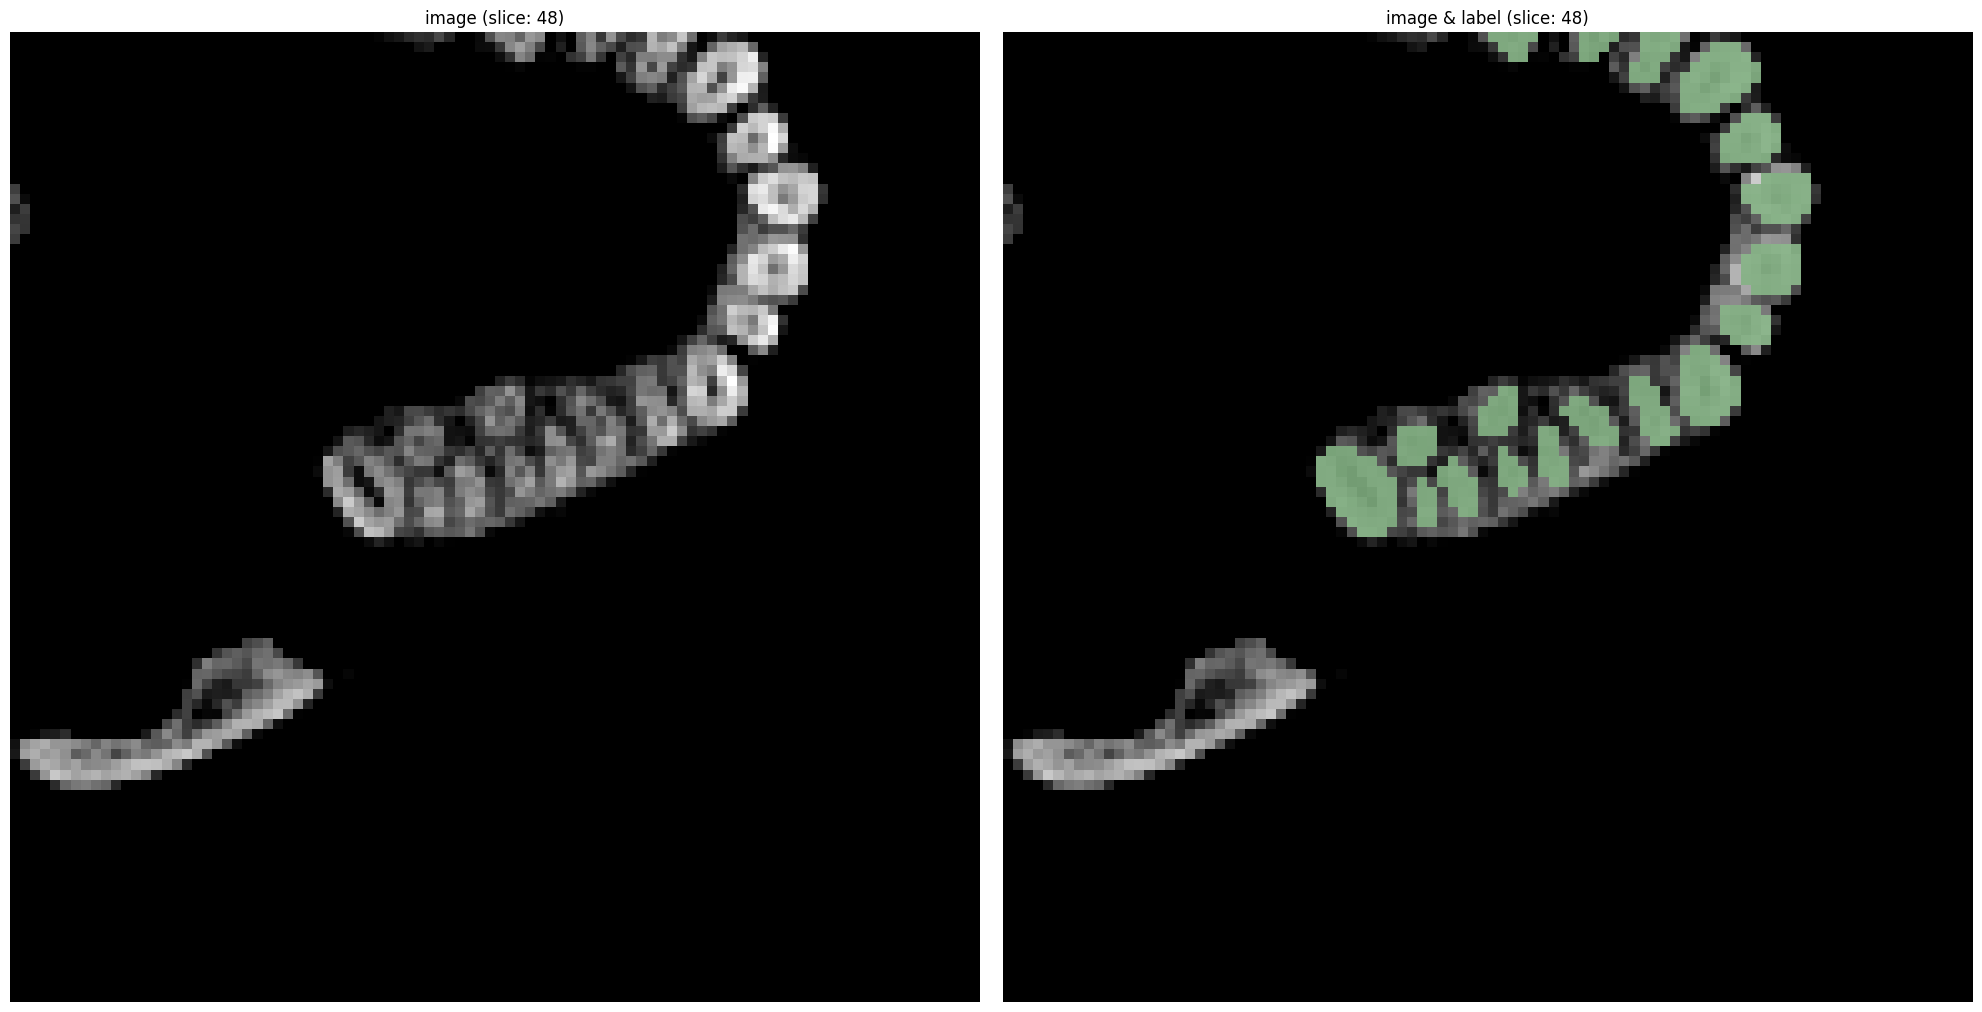

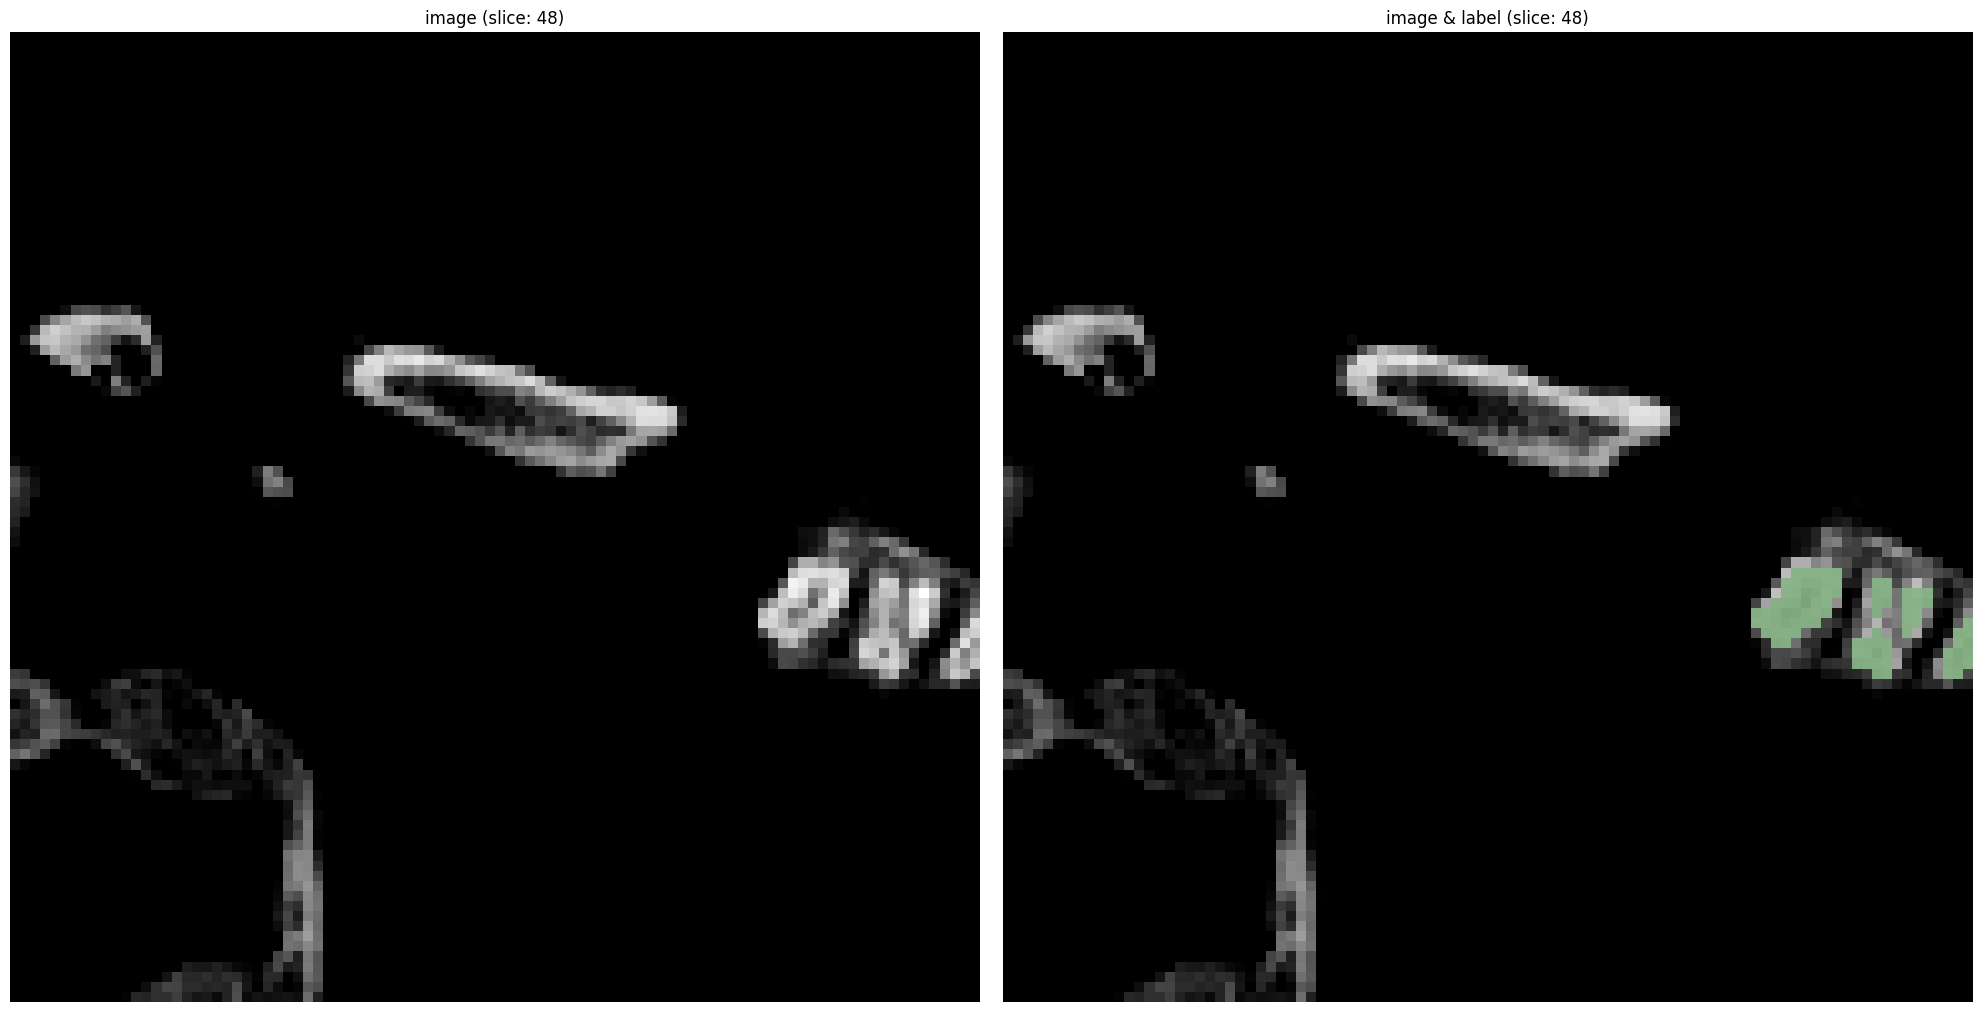

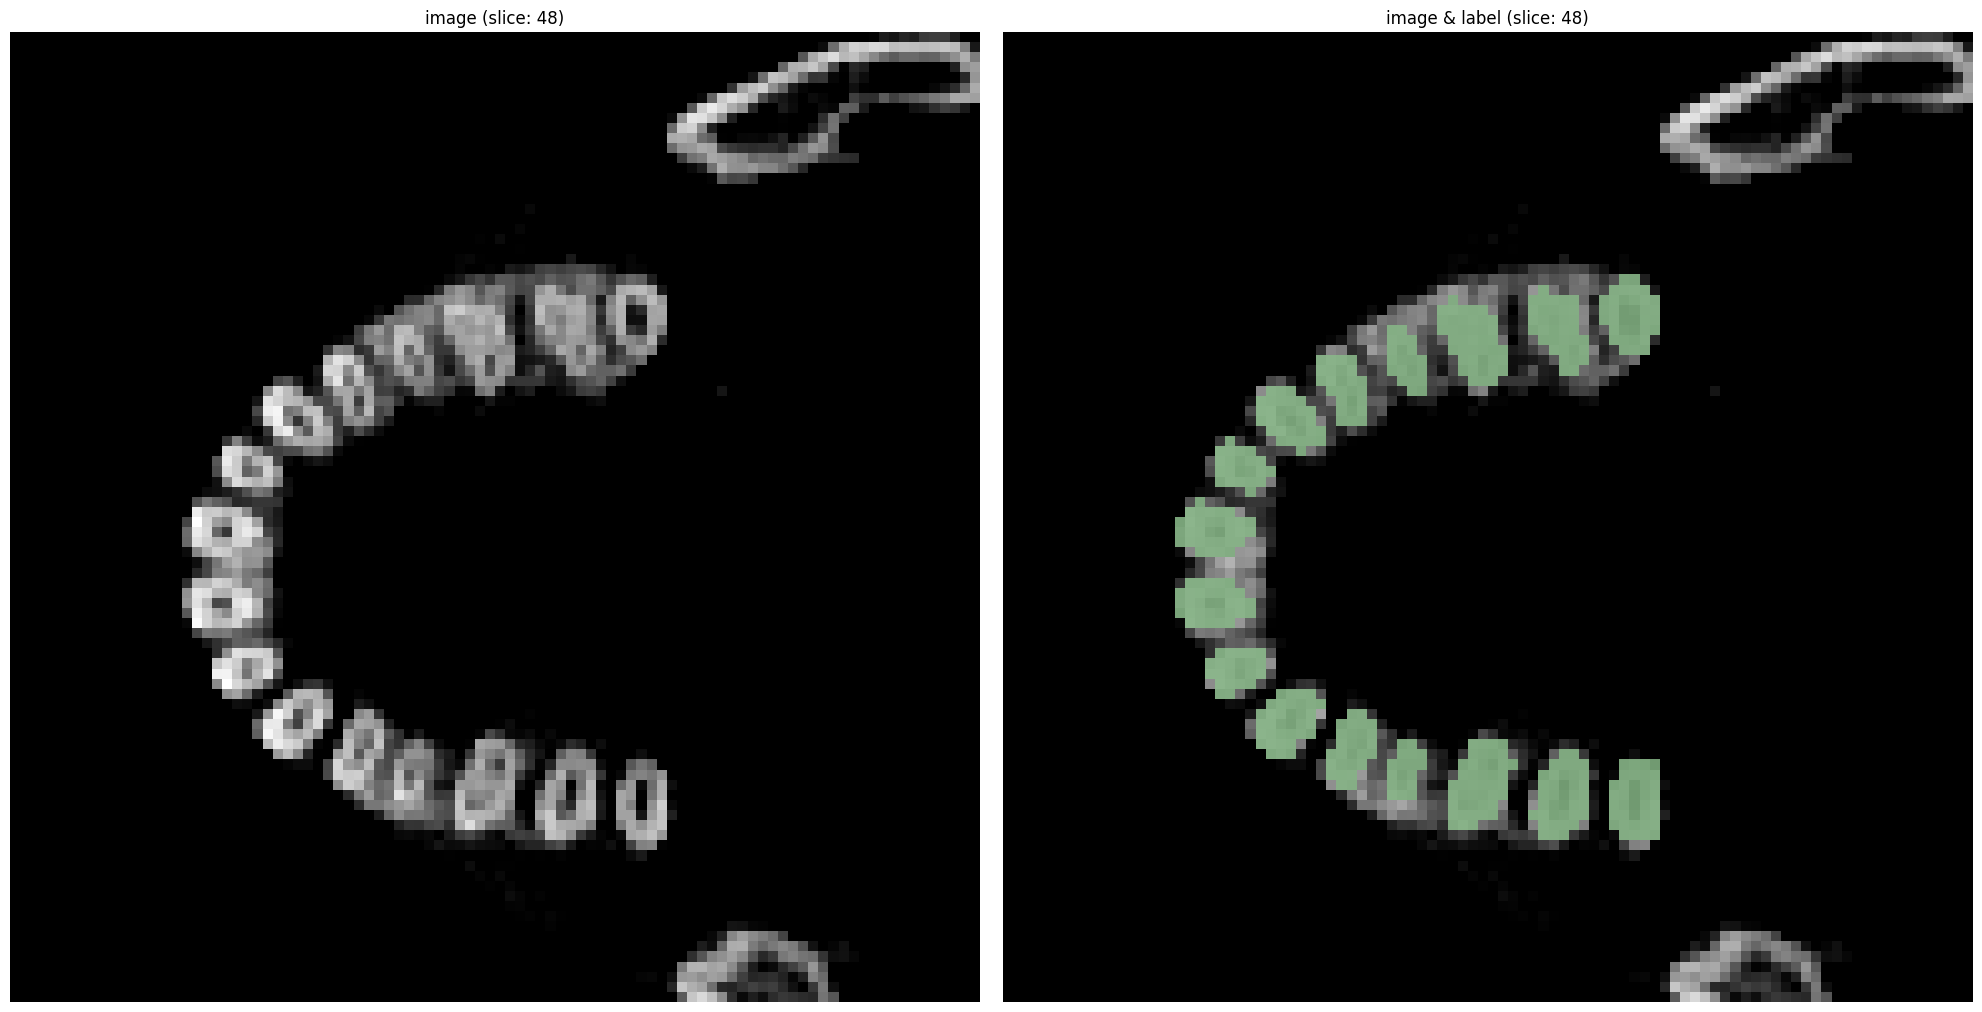

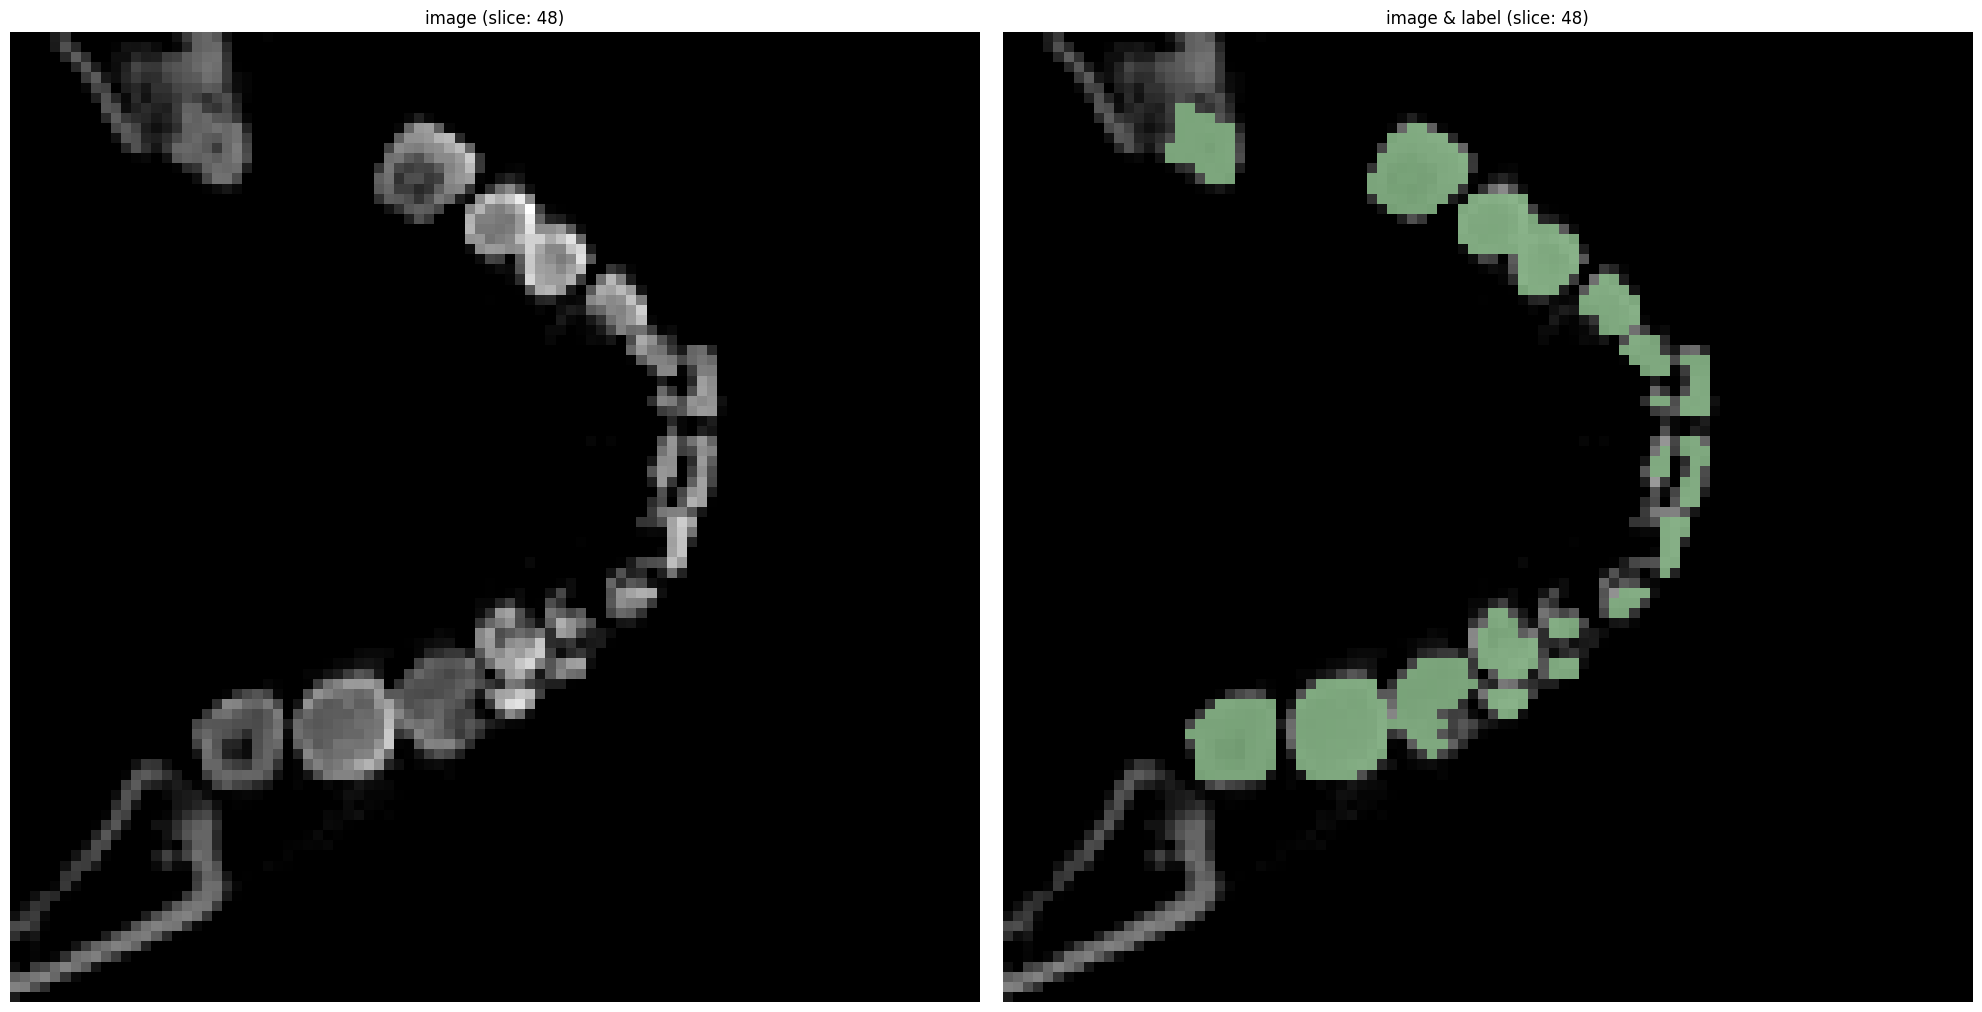

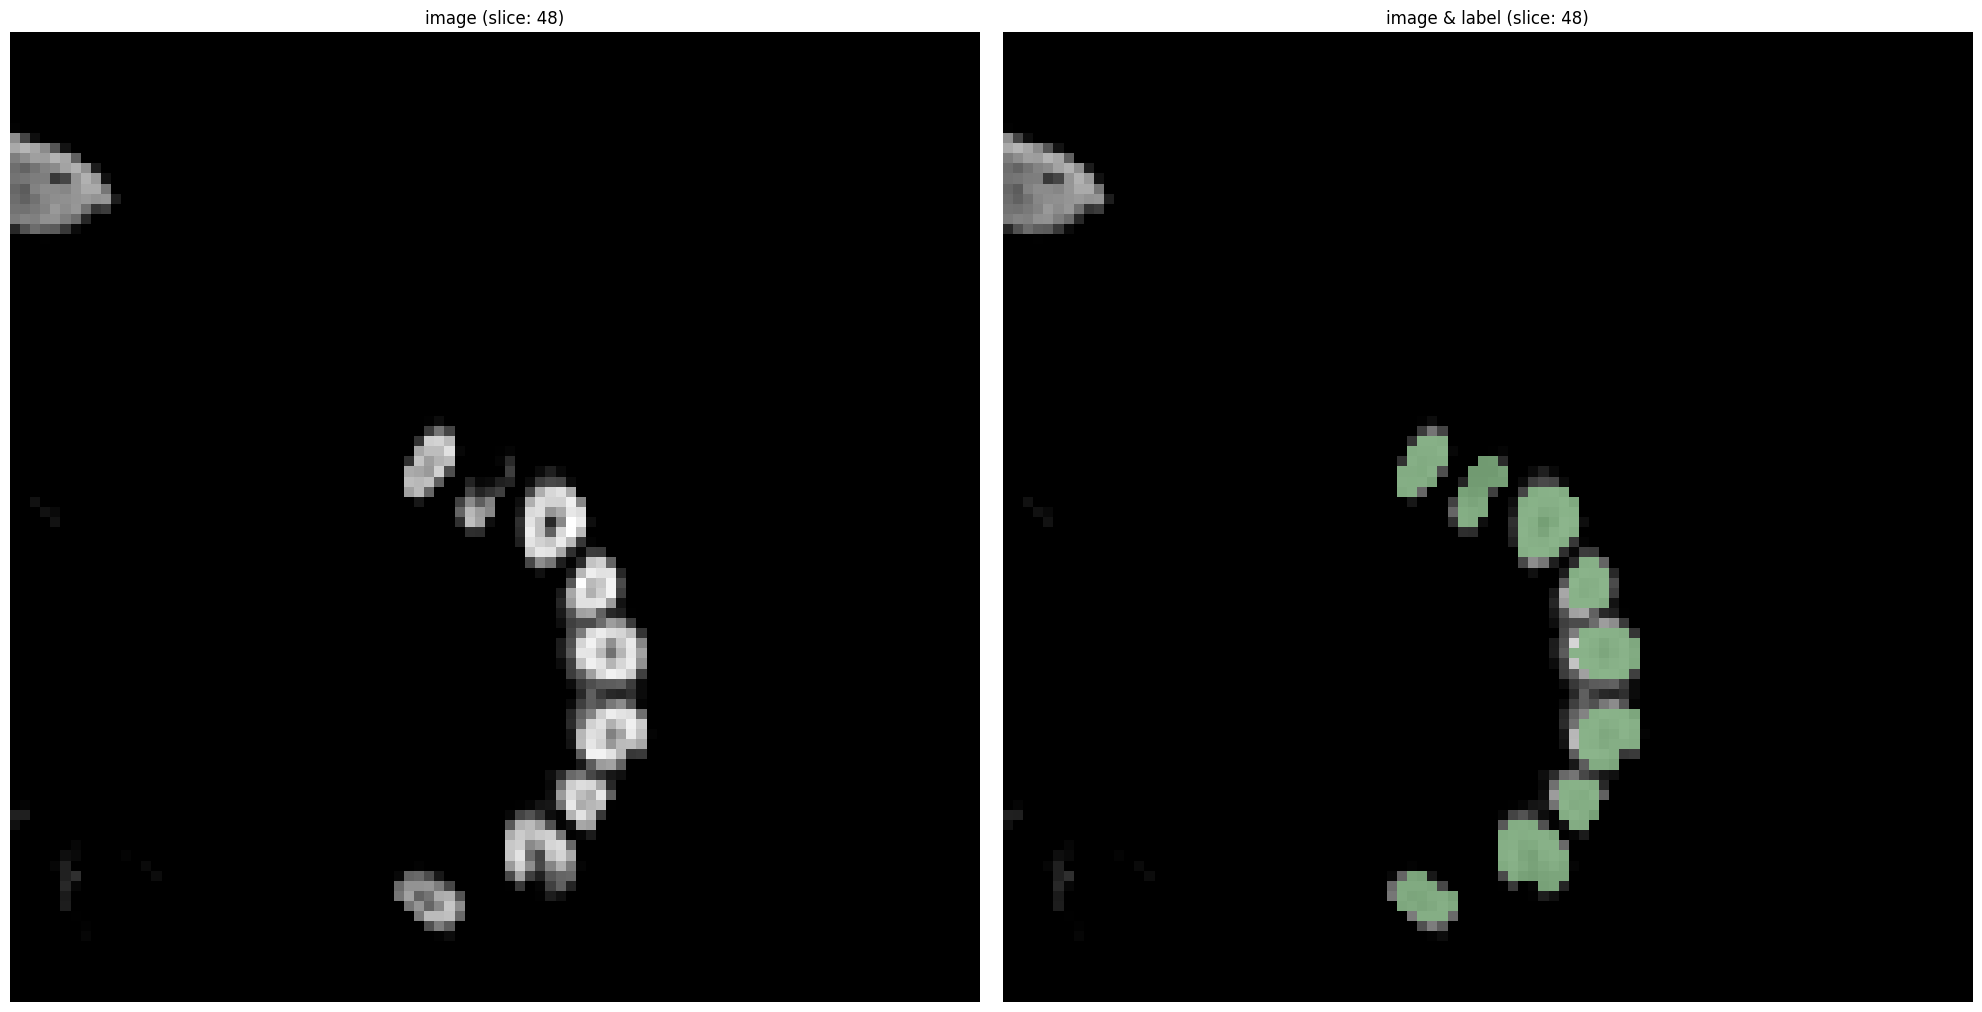

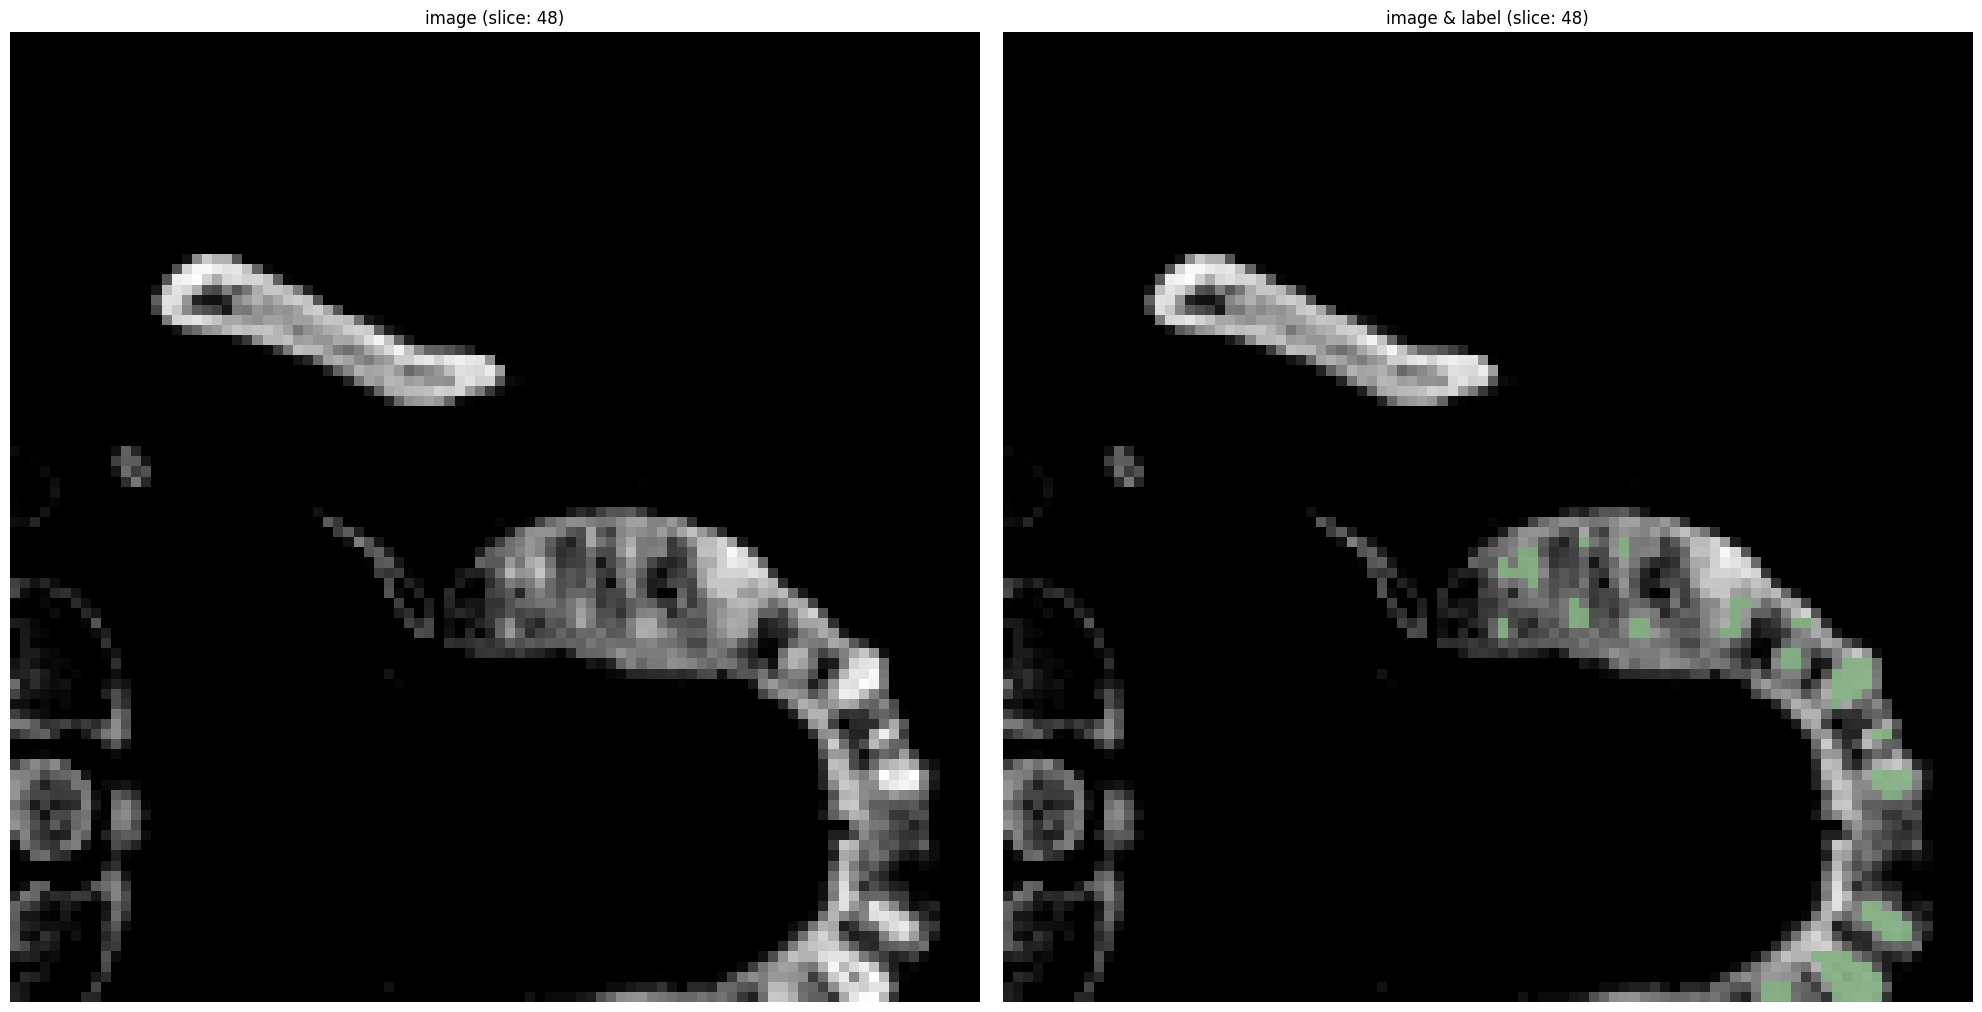

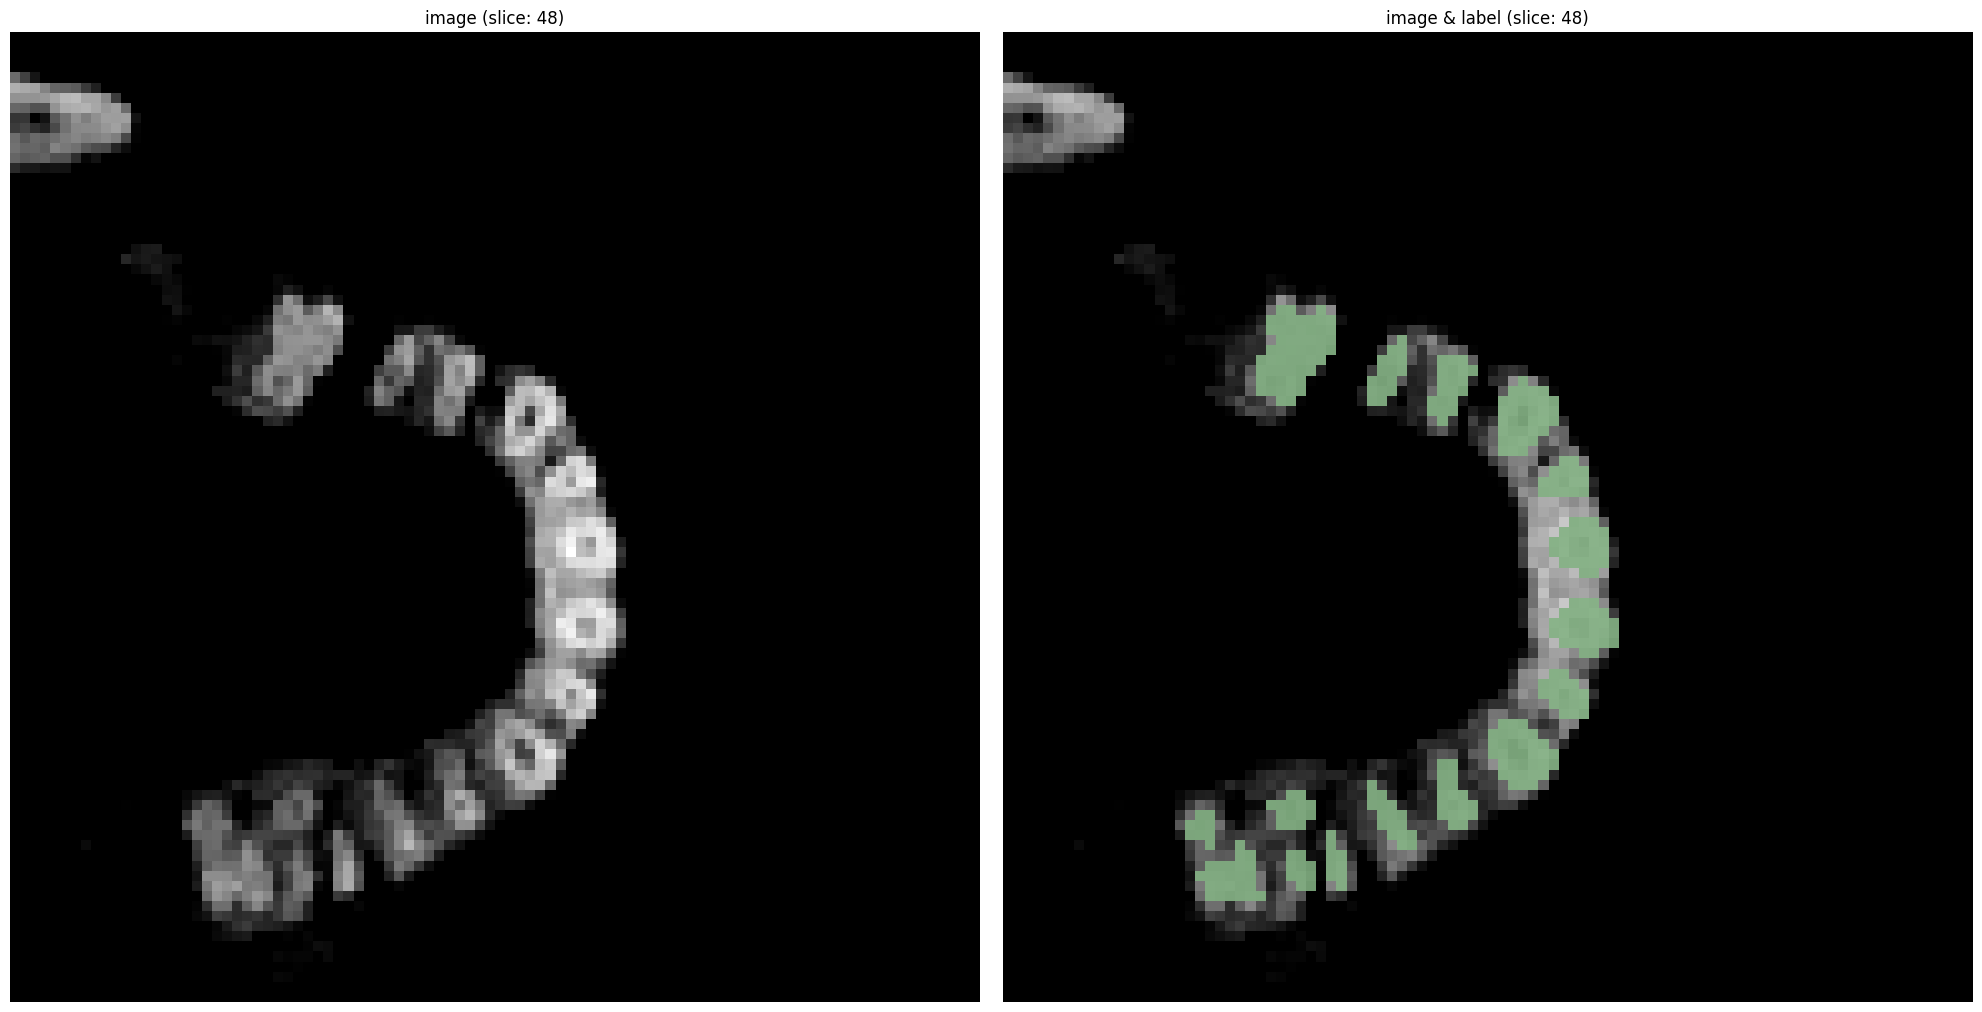

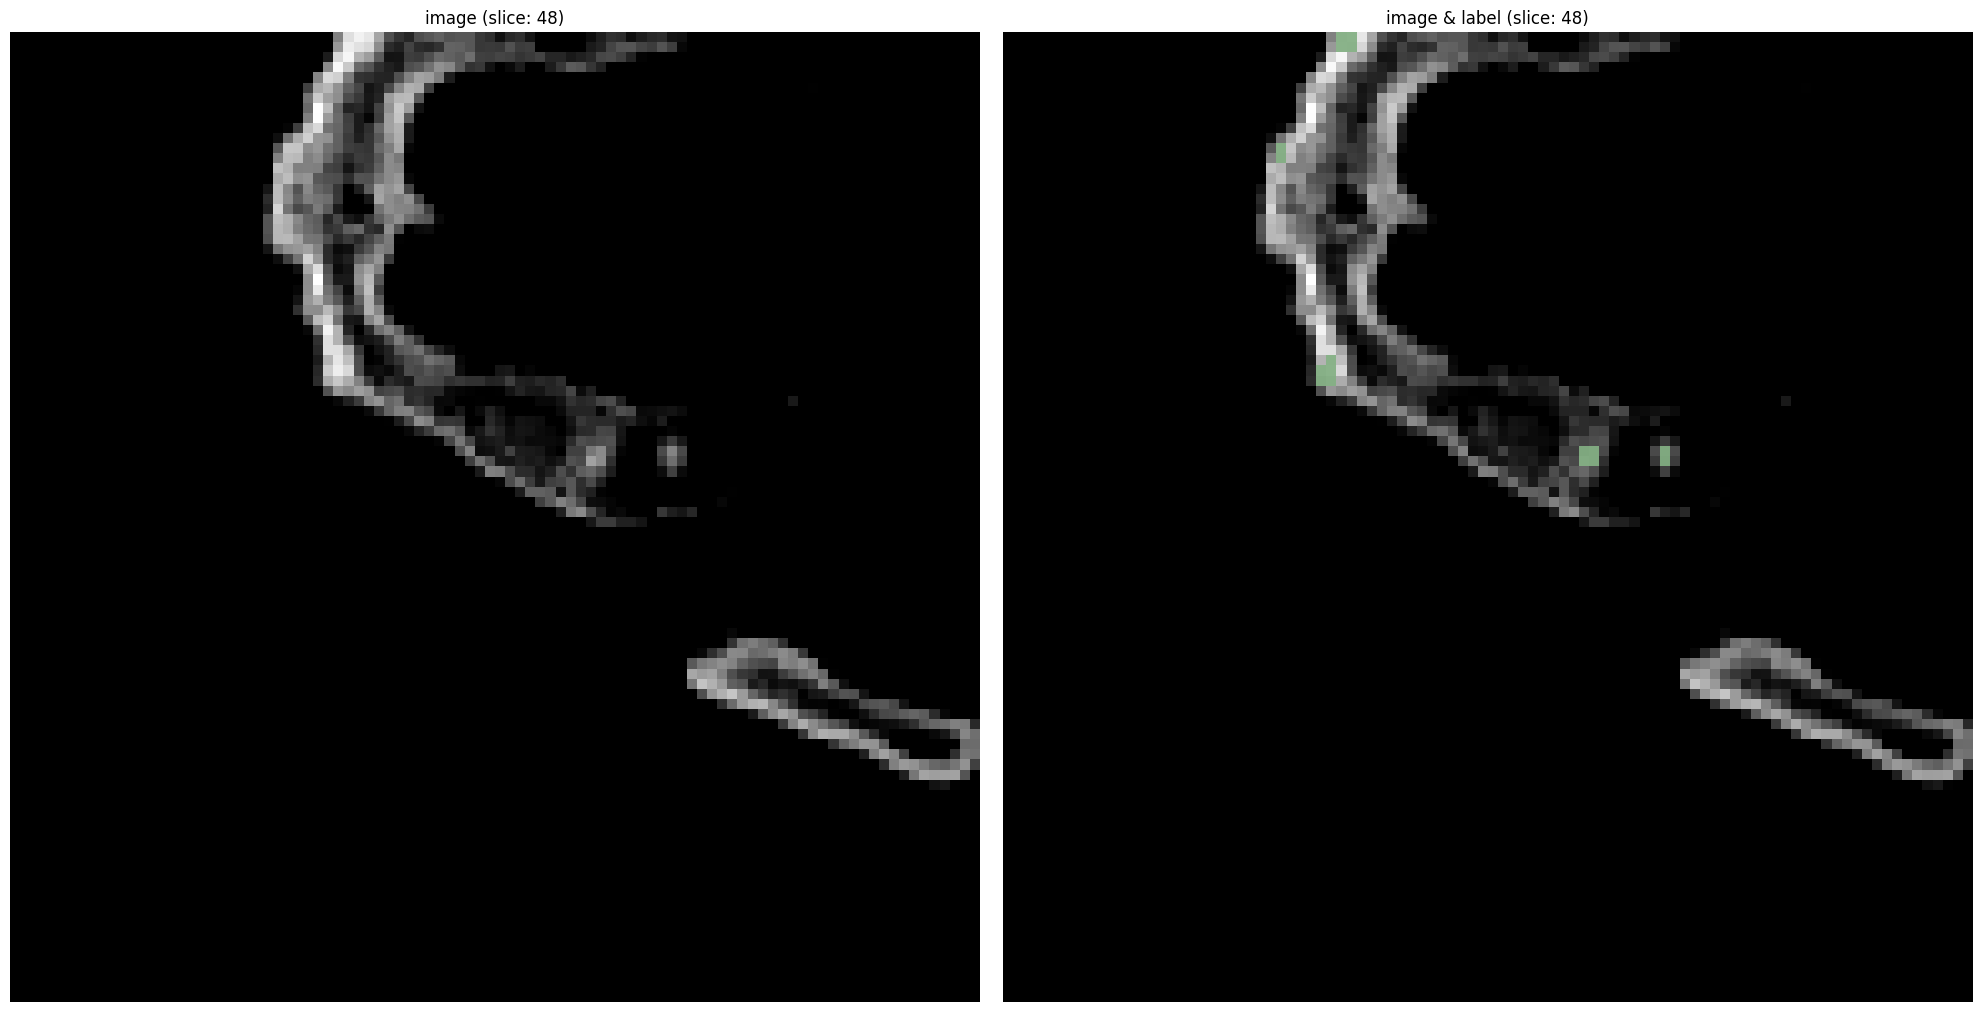

In [9]:
args = get_parser([])
args.data_name = 'tooth'
args.data_dir = data_dir
args.data_dicts_json = data_json
args.scale_intensity_type='range'
args.select_label_num=29
args.a_min=218
args.a_max=3187
args.roi_x=96
args.roi_y=96
args.roi_z=96
args.space_x=1.0
args.space_y=1.0
args.space_z=1.0

tr_ld, val_dl = DataLoader(args.data_name, args)

slice_idx = 48
num_classes = 2
for d in tr_ld:
    show_img_lbl(
        d['image'][0,0,:,:,slice_idx], 
        d['label'][0,0,:,:,slice_idx], 
        slice_idx=slice_idx,
        num_classes=num_classes
    )